# Intro
This notebook contained main analysis on psychophysical data, including:
- sorting and saving raw data 
- fitting and plotting psychometric function 
- estimating psychometric measures JND and PSE
- running suppl. tests 

# Set up

In [2]:
# Set up

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_analysis.load_data import LoadData
from data_analysis.fit_pf_nls import FitPf
from data_analysis.fit_noise import FitNoise
import pyiris.colorspace as pyc



def color4plot(theta_array):
    """
    Generate colors for plotting.

    """
    colorspace = pyc.ColorSpace(bit_depth=8,
                                calibration_path='config/resources/10bit/calibration_10bit.json',
                                chromaticity=0.2)
    rgbs = colorspace.dklc2rgb(phi=theta_array * np.pi / 180)
    return rgbs


def merge_data_within_sub(sub, ll_dat, hh_dat, lh_dat):

    ll_dat['condition'] = 'LL'
    hh_dat['condition'] = 'HH'
    lh_dat['condition'] = 'LH'
    dat = pd.concat([ll_dat, hh_dat, lh_dat])
    dat['subject'] = sub
    
    return dat


def comp_within_sub(sub, fit_list, label_list, plots=False, ylims=[15, 10]):
    """
    Merge and plot JND or PSE across conditions for a single subject.
    param ylims: [abs ylim of JND, abs ylim of PSE]

    """
    
    all_fitdf_list = []
    
    for fit, label in zip(fit_list, label_list):
        fitdf = pd.DataFrame(fit).transpose()[['PSE', 'JND', 'PSE_err', 'JND_err']]
        fitdf['condition'] = label
        fitdf['subject'] = sub
        fitdf['trialN'] =  pd.DataFrame(fit).transpose()[['Trial N']]

        all_fitdf_list.append(fitdf)

    all_fitdf = pd.concat(all_fitdf_list)
    all_fitdf = all_fitdf.reset_index().rename(columns={'index': 'Hue Angle'})
    
    first = all_fitdf[all_fitdf['Hue Angle'] == all_fitdf['Hue Angle'].min()]
    first['Hue Angle'] = first['Hue Angle'].apply(lambda x: x + 360)


    last = all_fitdf[all_fitdf['Hue Angle'] == all_fitdf['Hue Angle'].max()]
    last['Hue Angle'] = last['Hue Angle'].apply(lambda x: x - 360)

    all_fitdf_plt = pd.concat([all_fitdf, first, last], 
                        ignore_index=False).sort_values('Hue Angle')
    
    # Plot JND and PSE
    if plots is True:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        dt_color = color4plot(np.sort(all_fitdf_plt['Hue Angle'].unique()))
        l_color = {'LL': [0.2, 0.2, 0.2],
                   'HH': [0.7, 0.7, 0.7], 
                   'LH': [0.5, 0.5, 0.5]}
        dt_size = 60
        
        first_x = 22.5
        xlim = [0 - first_x, 360 + first_x]
        x_ticks = np.linspace(0 + first_x, 360 + first_x, 8, endpoint=False)

        for a in ax:
            a.set_xlabel('hue angle (deg)')
            a.set_xlim(xlim)
            a.set_xticks(x_ticks)
            a.set_xticklabels(x_ticks, rotation=45)
        
        # Plot JND
        ax[0].set_title('Discrmination Thresholds, ' + sub)
        for key, grp in all_fitdf_plt.groupby(['condition']):
            ax[0].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'], 
                           label=key, linestyle='--', color=l_color[key], alpha=0.9, capsize=10)
            ax[0].scatter(x=grp['Hue Angle'], y=grp['JND'], color=dt_color, s=dt_size)
            
        
        ax[0].set_ylabel('JND (deg)')
        ax[0].set_ylim([0, ylims[0]])
        [ax[0].vlines(x, 0, ylims[0], colors='grey', linestyles='-', alpha=0.3) 
         for x in [0, 360, 112.5, 112.5+180]]
        # ax[0].set_yscale('log')
    

        # Plot PSE
        ax[1].set_title('Absolute and Relative Biases, ' + sub)
        for key, grp in all_fitdf_plt.groupby(['condition']):
            ax[1].errorbar(x=grp['Hue Angle'], y=grp['PSE'], yerr=grp['PSE_err'],
                           label=key, linestyle='--', color=l_color[key], alpha=0.9, capsize=10)
            ax[1].scatter(x=grp['Hue Angle'], y=grp['PSE'], color=dt_color, s=dt_size)
        
        ax[1].set_ylabel('PSE (deg)')
        ax[1].set_ylim([-ylims[1], ylims[1]])
        [ax[1].vlines(x, -ylims[1], ylims[1], colors='grey', linestyles='-', alpha=0.3) 
         for x in [0, 360, 112.5, 112.5+180]]
        
        plt.legend()
        plt.show()
             
    return all_fitdf

def reformat_pilot(pilot_df, columns):
    """
    For temporal use: reformat pilot data to present data 
    """
    df = pd.DataFrame(columns=columns)
    df['condition'] = pilot_df['Condition']
    df['subject'] = pilot_df['Subject']
    df['standard_stim'] = pilot_df['Hue Angle']
    df['actual_intensity'] = pilot_df['All Intensities']
    df['judge'] = pilot_df['All Responses']
    df['resp_as_larger'] = pilot_df['resp_as_larger']
    df['react_time'] = pilot_df['Reaction Time']
    return df


pygame 2.0.0 (SDL 2.0.12, python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Load data and fit to PF

## S01
Note that S01 completed 
- 4 sessions of all parameter sets in the LL condition.
- 4+4 sessions of all parameter sets in the HH condition, and the first 4 sessions were discarded.
- 4+4 sessions of parameter set12 in the LH condition, and the first 4 sessions were discarded.
- 4+3+4 sessions of parameter set34 in the LH condition:
    - the first 4 sessions were discarded
    - the 5th-7th sessions were measured with higher chromaticity (0.16 insted of 0.12)
    - the last 4 sessions were used in the analysis (index as [7, 8, 9, 10])

In [2]:
# Load data
s1_ll = LoadData('s01', data_path='data', sel_par=['LL_2x2']).read_data()
s1_hh = LoadData('s01', data_path='data', sel_par=['HH_2x2'], sel_ses_idx=[4 ,5 ,6, 7]).read_data()
s1_lh = pd.concat([LoadData('s01', data_path='data', sel_par=['LH_2x2_set1', 'LH_2x2_set2'], sel_ses_idx=[4 ,5 ,6, 7]).read_data(),
                    LoadData('s01', data_path='data', sel_par=['LH_2x2_set3', 'LH_2x2_set4'], sel_ses_idx=[7, 8, 9, 10]).read_data()])

s1_data = merge_data_within_sub('s01', s1_ll, s1_hh, s1_lh)

# LL
s1_ll_FitPf = FitPf(s1_ll)
s1_ll_fit = s1_ll_FitPf.fit()
s1_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/s1_LL')
# s1_ll_FitPf.plot_pf_param()

# HH
s1_hh_FitPf = FitPf(s1_hh)
s1_hh_fit = s1_hh_FitPf.fit()
s1_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/s1_HH')
# s1_hh_FitPf.plot_pf_param()

# LH
s1_lh_FitPf = FitPf(s1_lh)
s1_lh_fit = s1_lh_FitPf.fit()
s1_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s1_LH')
# s1_lh_FitPf.plot_pf_param()

s1_fit = comp_within_sub('s1', 
                          [s1_ll_fit, s1_hh_fit, s1_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True)
                          
# Save data and estimates
# s1_data.to_csv('data/s01/s1_data.csv')
# s1_fit.to_csv('data_analysis/pf_estimates/s1_fit.csv')


KeyboardInterrupt: 

### Suppl. Test 1: chromaticity increased from 0.12 to 0.16...

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

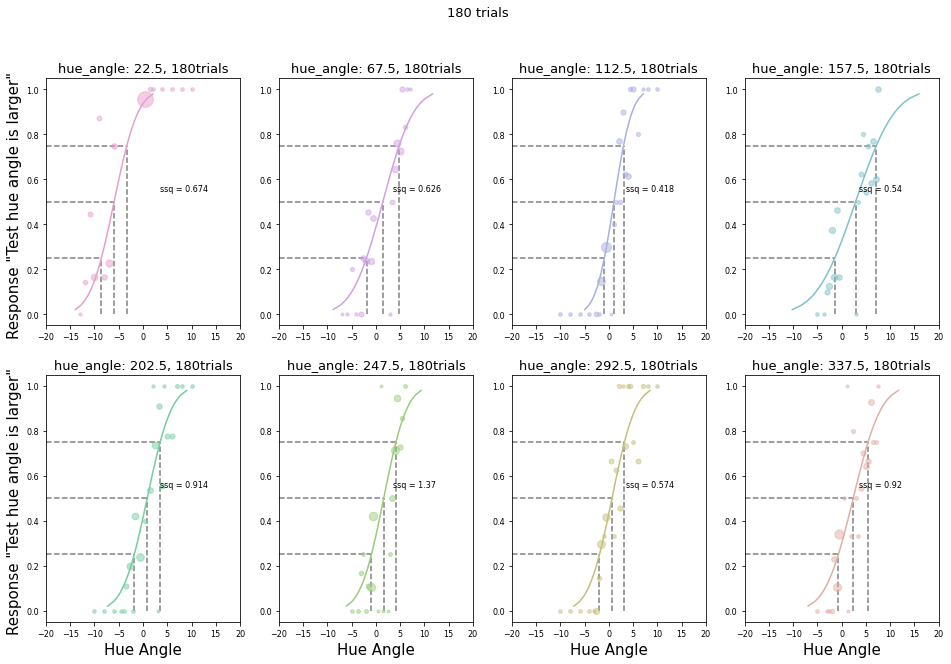

In [ ]:
s1_lh_high_chroma = LoadData('s01', data_path='data', sel_par=['LH_2x2'], sel_ses_idx=[4, 5, 6]).read_data()

FitPf(s1_lh_high_chroma).plot_pf_curve()
# FitPf(s1_lh_high_chroma).plot_pf_param()

### Suppl. Test2: with higher noise (width=30) 

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


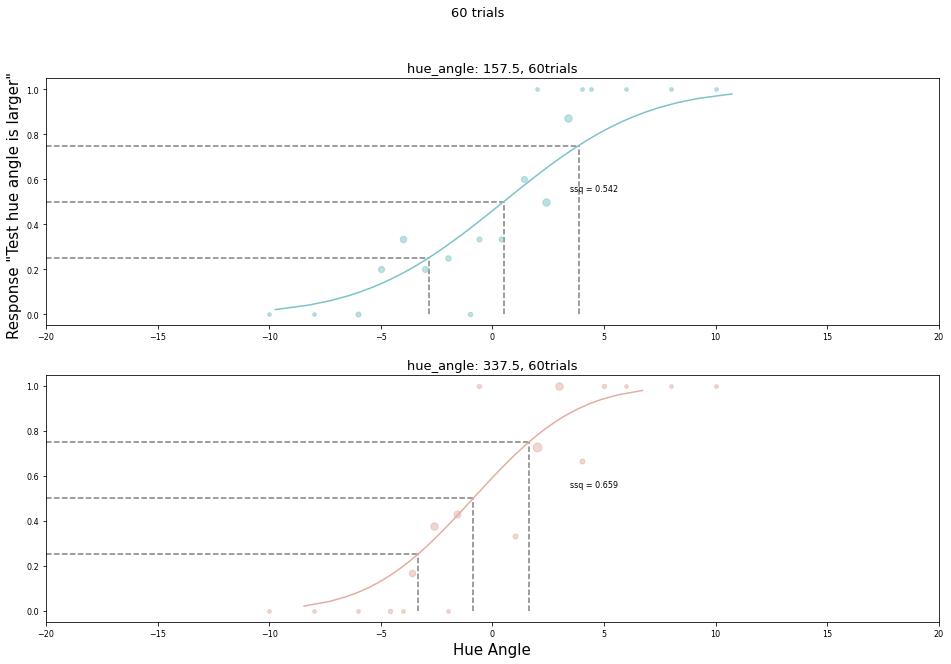

In [ ]:
s1_lh_high_noise = LoadData('s01', data_path='data', sel_par=['LH_higher_noise_2x2_set4']).read_data()

FitPf(s1_lh_high_noise).plot_pf_curve()
# FitPf(s1_lh_high_noise).plot_pf_param()

## S02

S02 completed 5 repeats for all parameter set and 2 more extra repeats for parameter set 3 and set 4. 

For set12;
- as usual, there was only training before the first sesssion (session index as 0).

For set34:
- session [1, 2, 3] were immediately ran after training on set 34.
- session [0, 4, 5, 6] were ran without training on the same day.

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

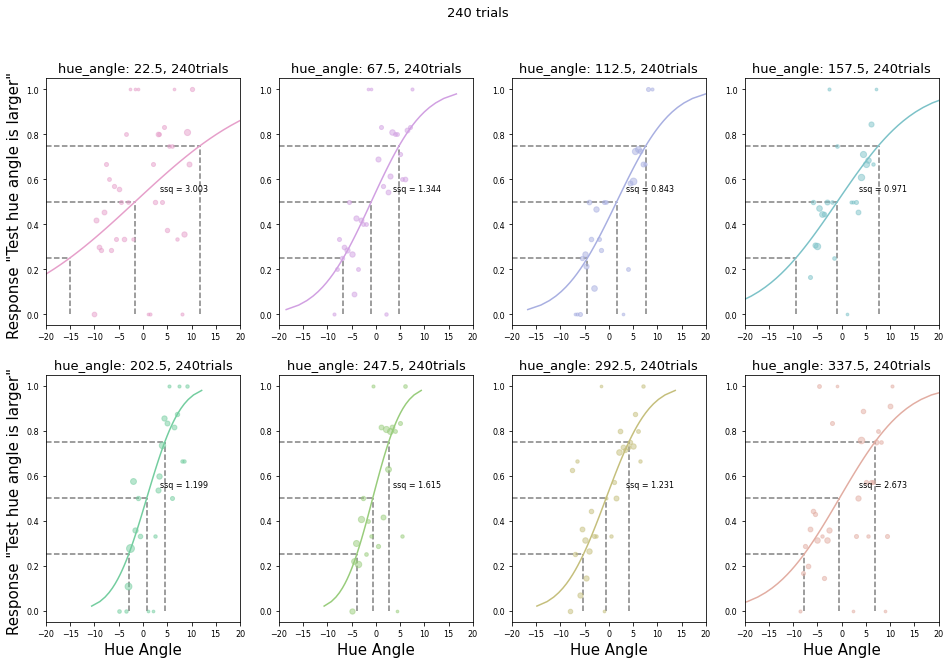

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


/Users/su/LRZ Sync+Share/colororder_v2/data_analysis/fit_pf_nls.py:196: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


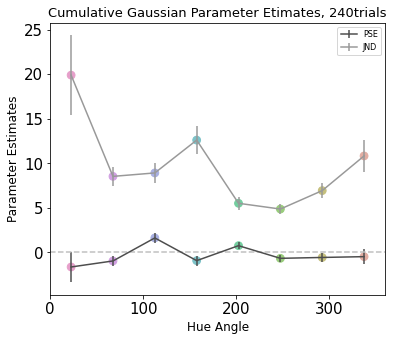

"\n# LH\ns2_lh_FitPf = FitPf(s2_lh)\ns2_lh_fit = s2_lh_FitPf.fit()\ns2_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s2_LH')\n# s2_lh_FitPf.plot_pf_param()\n\ns2_fit = comp_within_sub('s2', \n                          [s2_ll_fit, s2_hh_fit, s2_lh_fit], \n                          ['LL', 'HH', 'LH'], \n                          plots=True)\n"

In [320]:
# Load data
s2_sel_idx_12 = [1, 2, 3, 4]
s2_sel_idx_34 = [3, 4, 5, 6]

s2_ll = pd.concat([LoadData('s02', data_path='data', sel_par=['LL_2x2_set1','LL_2x2_set2'], sel_ses_idx=s2_sel_idx_12).read_data(),
                    LoadData('s02', data_path='data', sel_par=['LL_2x2_set3','LL_2x2_set4'], sel_ses_idx=s2_sel_idx_34).read_data()])

s2_hh = pd.concat([LoadData('s02', data_path='data', sel_par=['HH_2x2_set1','HH_2x2_set2'], sel_ses_idx=s2_sel_idx_12).read_data(),
                    LoadData('s02', data_path='data', sel_par=['HH_2x2_set3','HH_2x2_set4'], sel_ses_idx=s2_sel_idx_34).read_data()])

s2_lh = pd.concat([LoadData('s02', data_path='data', sel_par=['LH_2x2_set1','LH_2x2_set2'], sel_ses_idx=s2_sel_idx_12).read_data(),
                    LoadData('s02', data_path='data', sel_par=['LH_2x2_set3','LH_2x2_set4'], sel_ses_idx=s2_sel_idx_34).read_data()])

s2_data = merge_data_within_sub('s02', s2_ll, s2_hh, s2_lh)

# LL
s2_ll_FitPf = FitPf(s2_ll, guess=[0, 2])
s2_ll_fit = s2_ll_FitPf.fit()
s2_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/s2_LL')
# s2_ll_FitPf.plot_pf_param()

# HH
s2_hh_FitPf = FitPf(s2_hh)
s2_hh_fit = s2_hh_FitPf.fit()
s2_hh_FitPf.plot_pf_curve()
s2_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/s2_HH')
# s2_hh_FitPf.plot_pf_param()

# LH
s2_lh_FitPf = FitPf(s2_lh)
s2_lh_fit = s2_lh_FitPf.fit()
s2_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s2_LH')
# s2_lh_FitPf.plot_pf_param()

s2_fit = comp_within_sub('s2', 
                          [s2_ll_fit, s2_hh_fit, s2_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True)
"""
# Save data and estimates
# s2_data.to_csv('data/s02/s2_data.csv')
# s2_fit.to_csv('data_analysis/pf_estimates/s2_fit.csv')


### Suppl. Test: LH data when set34 training is always before the tests...

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

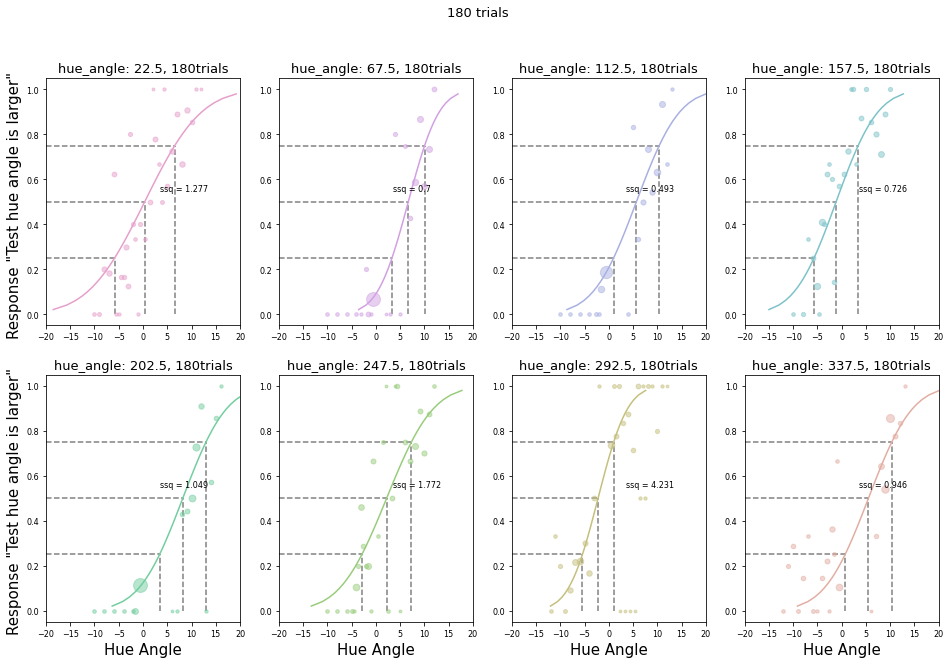

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


/Users/su/LRZ Sync+Share/colororder_v2/fit_pf_nls.py:189: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


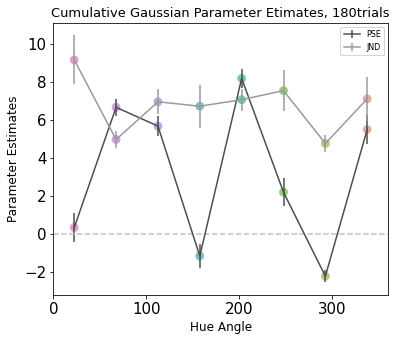

In [ ]:
s2_lh_train = LoadData('s02', data_path='data', sel_par=['LH_2x2'], sel_ses_idx=[1, 2, 3]).read_data()
FitPf(s2_lh_train).plot_pf_curve()
FitPf(s2_lh_train).plot_pf_param()

### Suppl. Test: lower noise for set34, with par file `s02_LH_lower_noise_1_2x2_*`

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


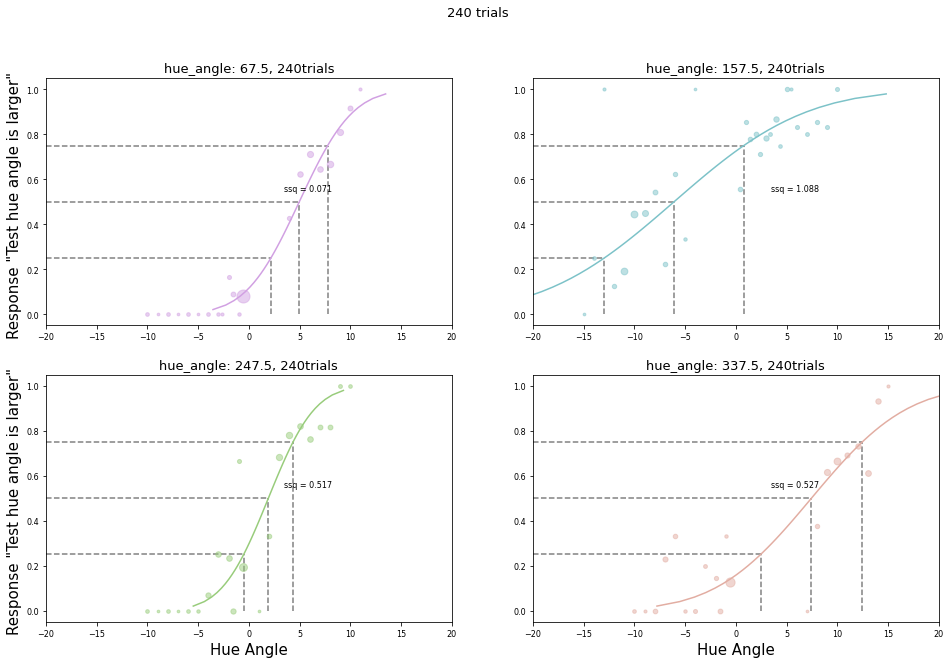

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


/Users/su/LRZ Sync+Share/colororder_v2/data_analysis/fit_pf_nls.py:196: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


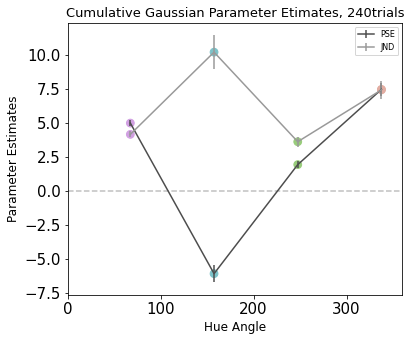

In [253]:
s2_lh_set34_lower = LoadData('s02', data_path='data', sel_par=['LH_lower_noise_1_2x2']).read_data()
FitPf(s2_lh_set34_lower).plot_pf_curve()
FitPf(s2_lh_set34_lower).plot_pf_param()

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


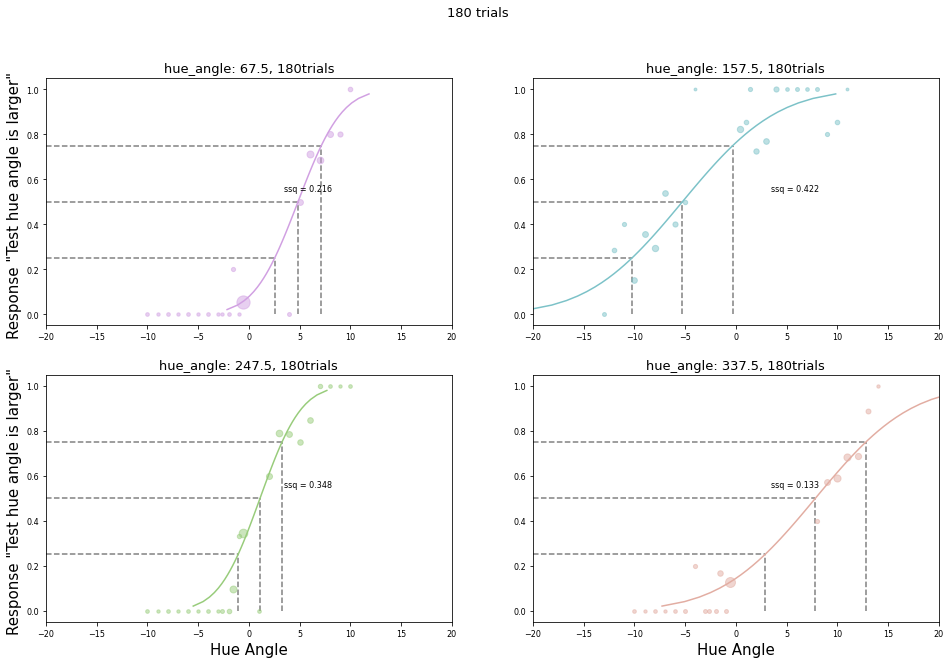

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


/Users/su/LRZ Sync+Share/colororder_v2/data_analysis/fit_pf_nls.py:196: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


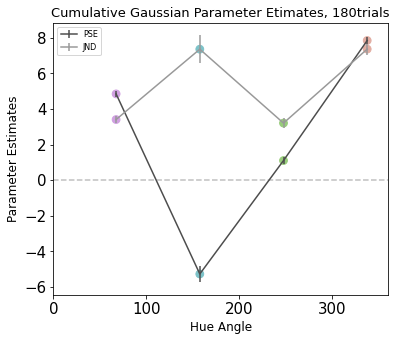

In [254]:
s2_lh_set34_higher = LoadData('s02', data_path='data', sel_par=['LH_2x2'], sel_ses_idx=[7, 8, 9, 10]).read_data()
FitPf(s2_lh_set34_higher).plot_pf_curve()
FitPf(s2_lh_set34_higher).plot_pf_param()

## S03
Note that 60 trials (1 session) of each stimulus and condition were tested WITHOUT isoslant, and they are indexed in `s03_no_iso.yaml`. These trials of LL condition were kept for the analysis and indexed in `s03.yaml`, as the non-uniform luminance might affect less in the uniform hues.

All trials in HH or LH used stimuli WITH isoslant.

In [4]:
# Load data
s3_ll = LoadData('s03', data_path='data', sel_par=['LL_2x2']).read_data()
s3_hh = LoadData('s03', data_path='data', sel_par=['HH_2x2']).read_data()
s3_lh = LoadData('s03', data_path='data', sel_par=['LH_2x2']).read_data()

s3_data = merge_data_within_sub('s03', s3_ll, s3_hh, s3_lh)


# LL
s3_ll_FitPf = FitPf(s3_ll)
s3_ll_fit = s3_ll_FitPf.fit()
s3_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/s3_LL')

# HH
s3_hh_FitPf = FitPf(s3_hh)
s3_hh_fit = s3_hh_FitPf.fit()
s3_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/s3_HH')

# LH
s3_lh_FitPf = FitPf(s3_lh)
s3_lh_fit = s3_lh_FitPf.fit()
s3_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s3_LH')


s3_fit = comp_within_sub('s3', 
                          [s3_ll_fit, s3_hh_fit, s3_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True)

# Save data and estimates
s3_data.to_csv('data/s03/s3_data.csv')
s3_fit.to_csv('data_analysis/pf_estimates/s3_fit.csv')


## S04


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

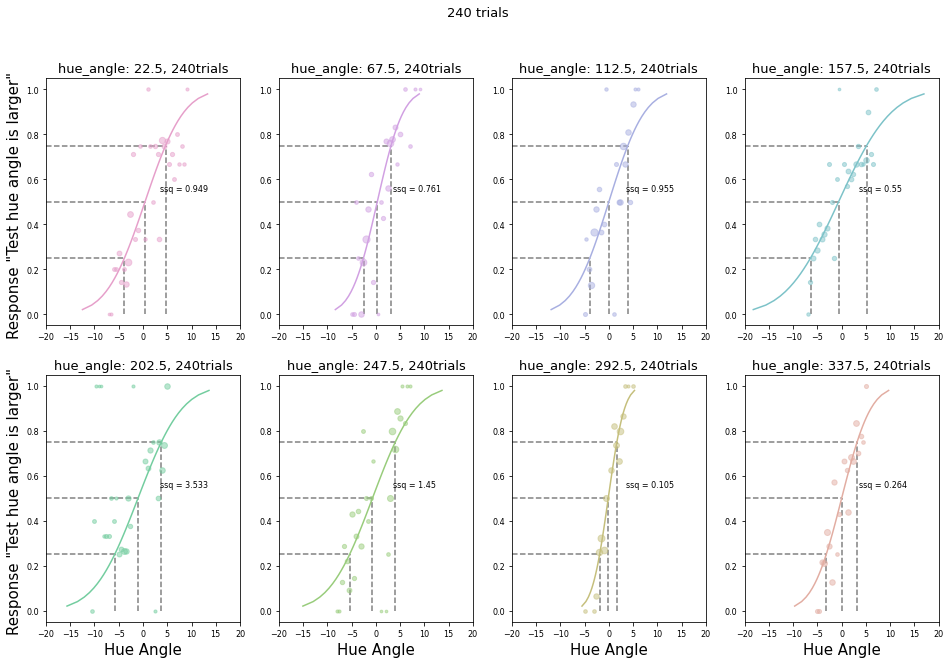

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

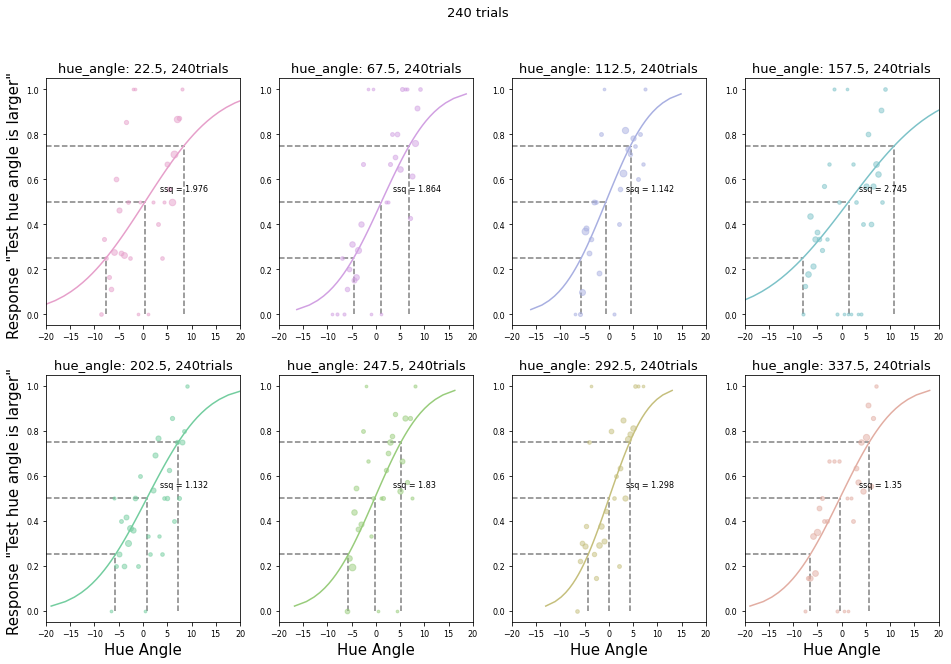

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

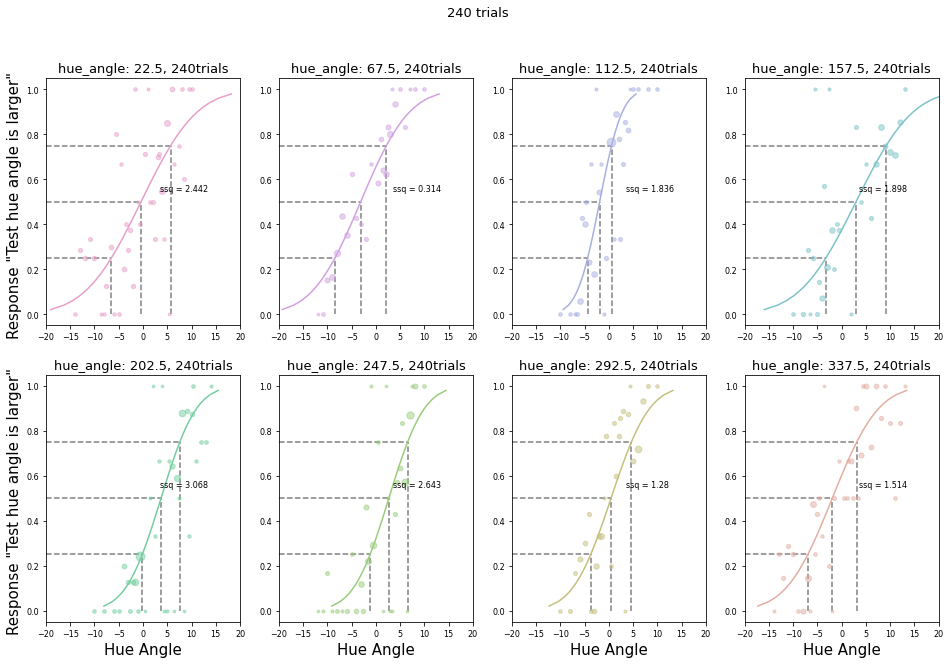

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


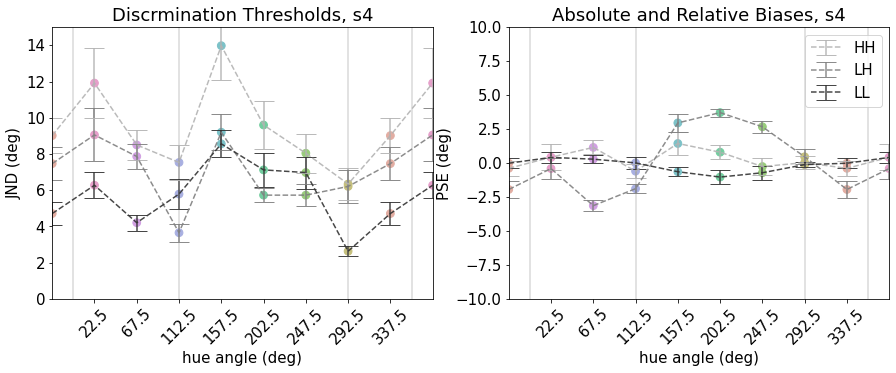

In [77]:
# Load data
s4_pre_ll = pd.read_csv('data/pre_sel_data.csv').query("Subject == 'ak' and Condition == 'L-L' ")
s4_ll = reformat_pilot(s4_pre_ll, s1_data.columns)

s4_hh = LoadData('s04', data_path='data', sel_par=['HH_2x2']).read_data()
s4_lh = LoadData('s04', data_path='data', sel_par=['LH_2x2']).read_data()

s4_data = merge_data_within_sub('s04', s4_ll, s4_hh, s4_lh)

# LL
s4_ll_FitPf = FitPf(s4_ll)
s4_ll_fit = s4_ll_FitPf.fit()
s4_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/s4_LL')
# s4_ll_FitPf.plot_pf_param()

# HH
s4_hh_FitPf = FitPf(s4_hh)
s4_hh_fit = s4_hh_FitPf.fit()
s4_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/s4_HH')
# s4_hh_FitPf.plot_pf_param()

# LH
s4_lh_FitPf = FitPf(s4_lh)
s4_lh_fit = s4_lh_FitPf.fit()
s4_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s4_LH')
# s4_lh_FitPf.plot_pf_param()

s4_fit = comp_within_sub('s4', 
                          [s4_ll_fit, s4_hh_fit, s4_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True)

# Save data and estimates
s4_data.to_csv('data/s04/s4_data.csv')
s4_fit.to_csv('data_analysis/pf_estimates/s4_fit.csv')


## S05

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

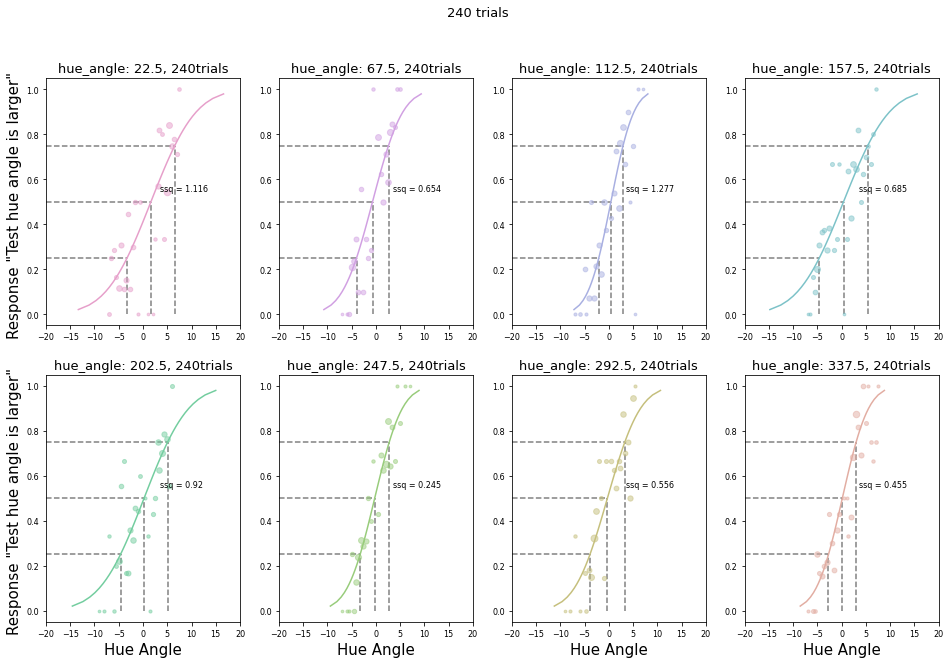

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

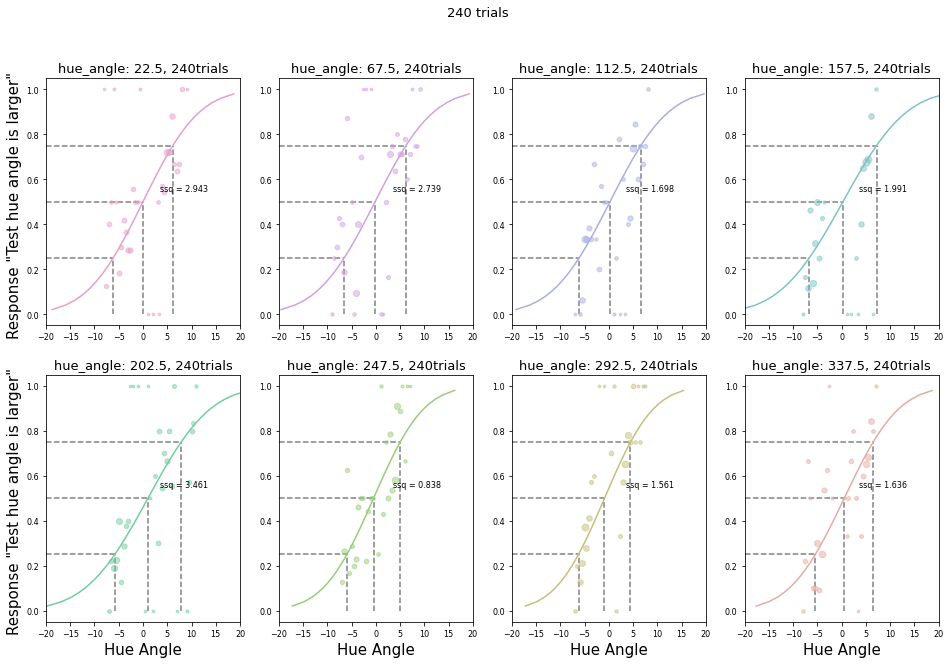

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

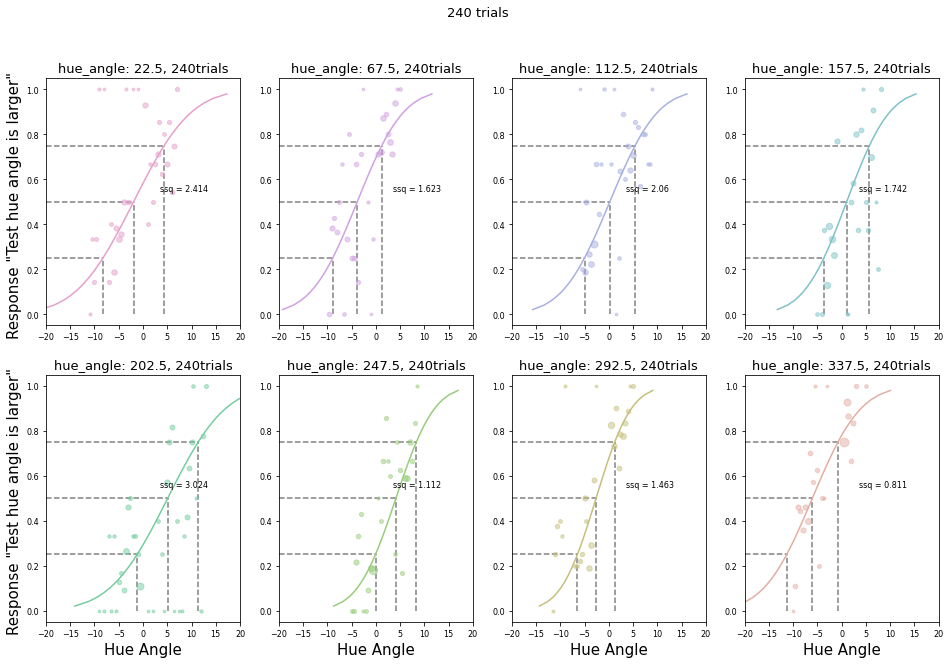

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


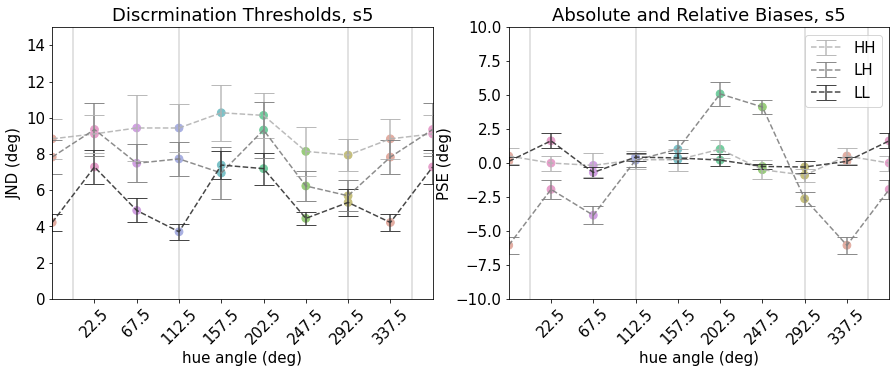

In [9]:
# Load data
s5_ll = LoadData('s05', data_path='data', sel_par=['LL_2x2']).read_data()
s5_hh = LoadData('s05', data_path='data', sel_par=['HH_2x2']).read_data()
s5_lh = LoadData('s05', data_path='data', sel_par=['LH_2x2']).read_data()

s5_data = merge_data_within_sub('s05', s5_ll, s5_hh, s5_lh)

# LL
s5_ll_FitPf = FitPf(s5_ll)
s5_ll_fit = s5_ll_FitPf.fit()
s5_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/s5_LL')
# s5_ll_FitPf.plot_pf_param()

# HH
s5_hh_FitPf = FitPf(s5_hh)
s5_hh_fit = s5_hh_FitPf.fit()
s5_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/s5_HH')
# s5_hh_FitPf.plot_pf_param()

# LH
s5_lh_FitPf = FitPf(s5_lh)
s5_lh_fit = s5_lh_FitPf.fit()
s5_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s5_LH')
# s5_lh_FitPf.plot_pf_param()

s5_fit = comp_within_sub('s5', 
                          [s5_ll_fit, s5_hh_fit, s5_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True)

# Save data and estimates
# s5_data.to_csv('data/s05/s5_data.csv')
# s5_fit.to_csv('data_analysis/pf_estimates/s5_fit.csv')


## S06
Note that s06 completed the 4 repeats each stimulus and condition WITHOUT isoslant adjustment. These HH and LH data are indexed in `s06_no_iso.yaml` and discarded from the analysis. The data of LL condition were kept for the analysis and indexed in `s06.yaml`, as the non-uniform luminance might affect less in the uniform hues.

For the data WITH isoslant adjustment, 
s06 also ran two more repeats of set34 by accident, and these sessions were not included in the analysis.

s06'data showed particularly a negative bias at stim4 (157.5 deg). A possible reason could be that the subject was not familiar with the color. In the end s06 performed again 4 sessions only for stim4, and the data were used for analysis although the bias remains. (The stimulus was used for lower noise testing, see Suppl.Test.).


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

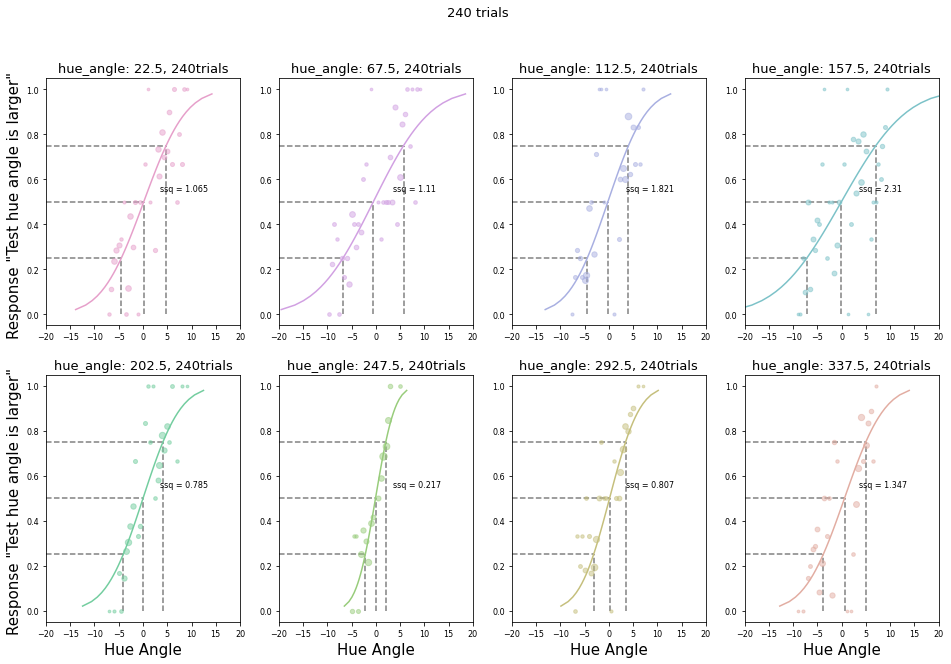

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

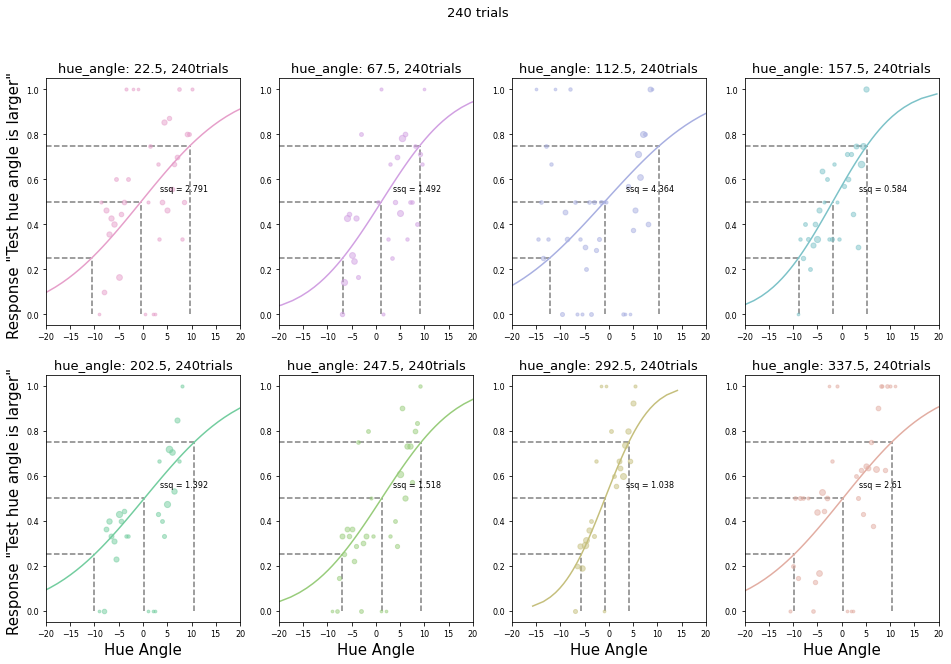

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

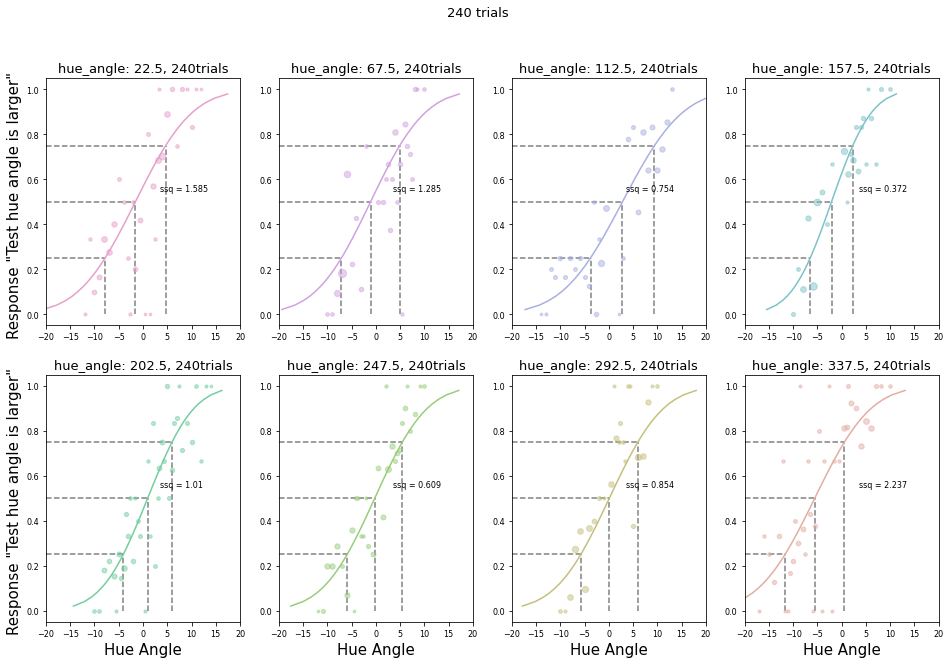

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


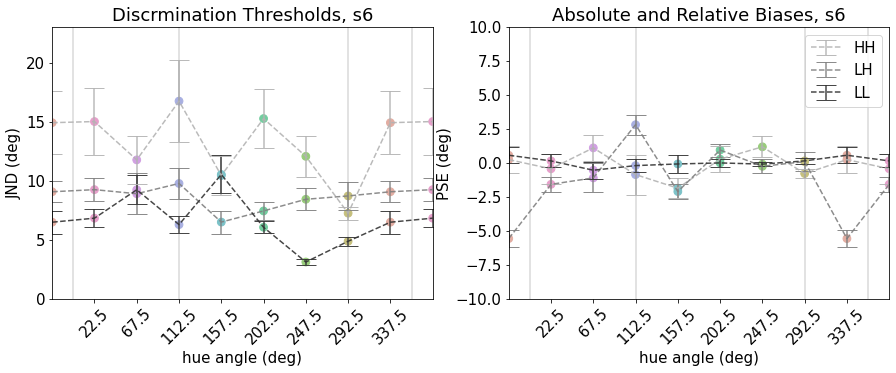

In [282]:
# Load data
s6_ll = LoadData('s06', data_path='data', sel_par=['LL_2x2']).read_data()
s6_hh = pd.concat([LoadData('s06', data_path='data', sel_par=['HH_2x2_set1', 'HH_2x2_set2']).read_data(),
                   LoadData('s06', data_path='data', sel_par=['HH_2x2_set3', 'HH_2x2_set4'], sel_ses_idx=[0, 1, 2, 3]).read_data()])  
s6_lh = pd.concat([LoadData('s06', data_path='data', sel_par=['LH_2x2_set1', 'LH_2x2_set2']).read_data(),
                   LoadData('s06', data_path='data', sel_par=['LH_2x2_set3'], sel_ses_idx=[0, 1, 2, 3]).read_data(), 
                   LoadData('s06', data_path='data', sel_par=['LH_2x2_set4'], sel_ses_idx=[0, 1, 2, 3]).read_data().query("standard_stim == 337.5"),
                   LoadData('s06', data_path='data', sel_par=['LH_2x2_stim4']).read_data()])  


s6_data = merge_data_within_sub('s06', s6_ll, s6_hh, s6_lh)


# LL
s6_ll_FitPf = FitPf(s6_ll)
s6_ll_fit = s6_ll_FitPf.fit()
s6_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/s6_LL')
# s6_ll_FitPf.plot_pf_param())

# HH
s6_hh_FitPf = FitPf(s6_hh)
s6_hh_fit = s6_hh_FitPf.fit()
s6_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/s6_HH')
# s6_hh_FitPf.plot_pf_param())

# LH
s6_lh_FitPf = FitPf(s6_lh)
s6_lh_fit = s6_lh_FitPf.fit()
s6_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/s6_LH')
# s6_lh_FitPf.plot_pf_param())

s6_fit = comp_within_sub('s6', 
                          [s6_ll_fit, s6_hh_fit, s6_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True, ylims=[23, 10])


# Save data and estimates
s6_data.to_csv('data/s06/s6_data.csv')
s6_fit.to_csv('data_analysis/pf_estimates/s6_fit.csv')


### Suppl. Test: lower noise for stim4

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


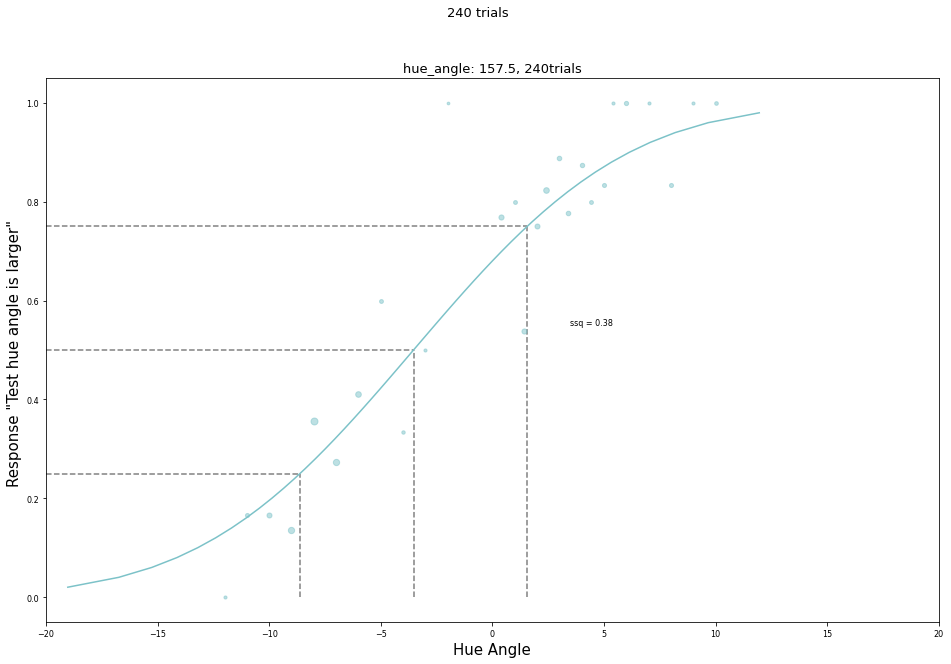

In [258]:
s6_lh_stim4_lower = LoadData('s06', data_path='data', sel_par=['LH_lower_noise']).read_data()
FitPf(s6_lh_stim4_lower).plot_pf_curve()

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


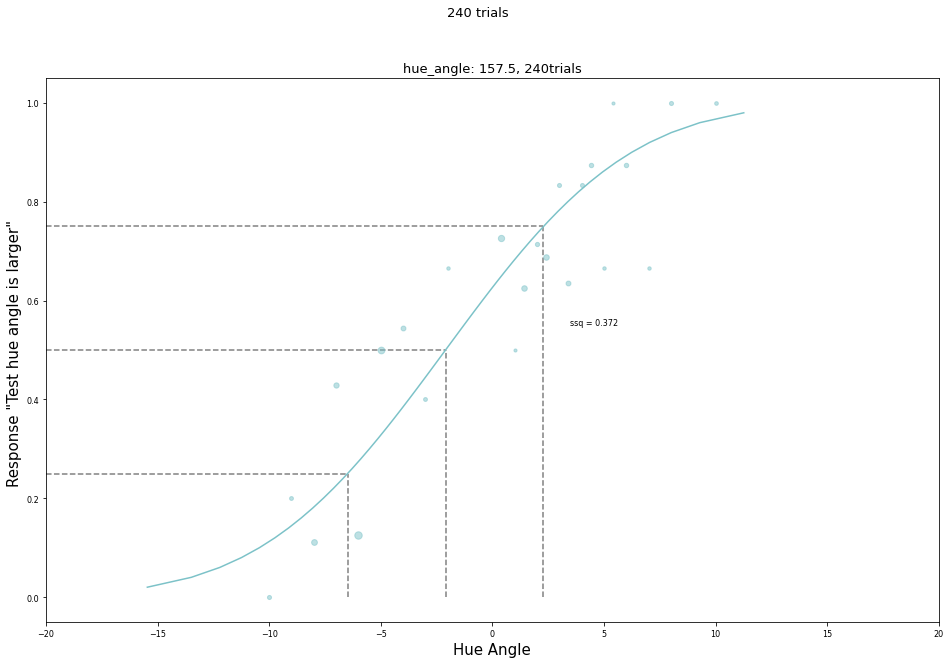

In [259]:

s6_lh_stim4_higher = LoadData('s06', data_path='data', sel_par=['LH_2x2_stim4']).read_data()
FitPf(s6_lh_stim4_higher).plot_pf_curve()

## S07
Note that s07 data are excluded from further analysis.

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

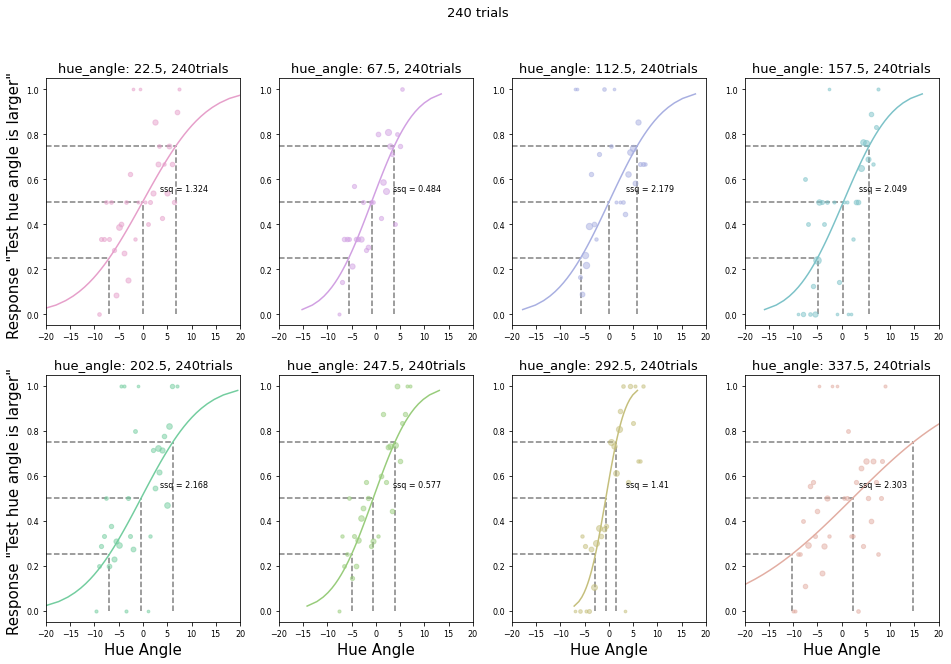

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

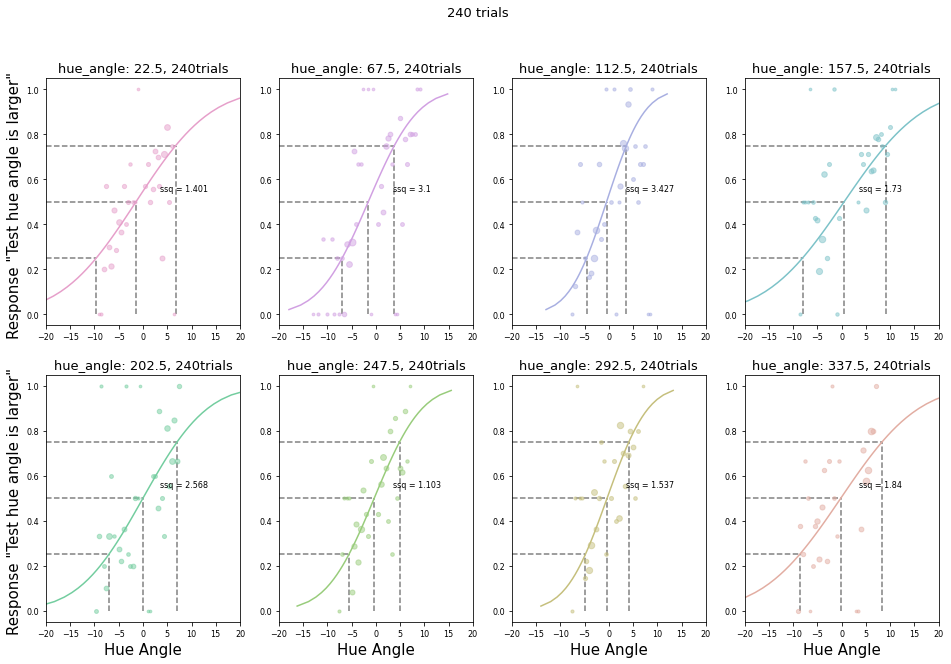

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

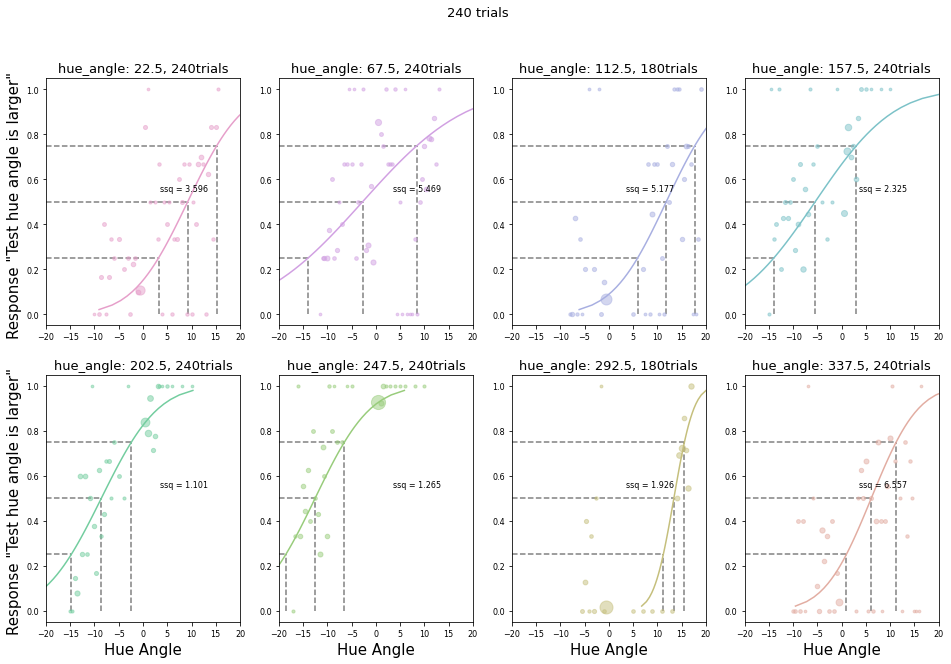

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


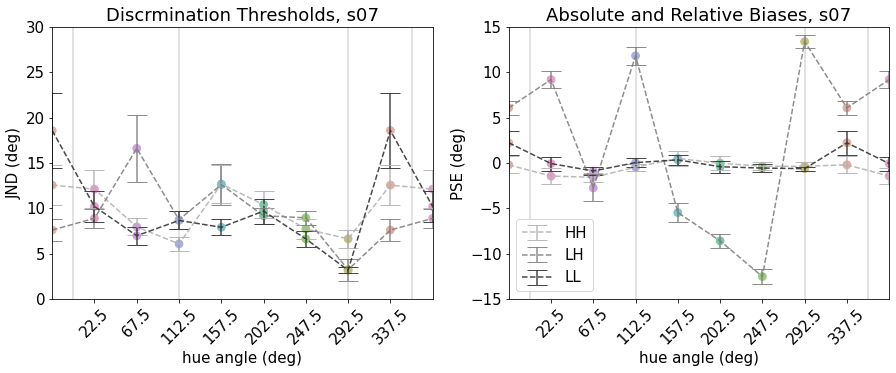

In [15]:
# Load data
s7_ll = LoadData('s07', data_path='data', sel_par=['LL_2x2']).read_data()
s7_hh = LoadData('s07', data_path='data', sel_par=['HH_2x2']).read_data()
s7_lh = LoadData('s07', data_path='data', sel_par=['LH_2x2']).read_data()

s7_data = merge_data_within_sub('s07', s7_ll, s7_hh, s7_lh)

# LL
s7_ll_FitPf = FitPf(s7_ll)
s7_ll_fit = s7_ll_FitPf.fit()
s7_ll_FitPf.plot_pf_curve()
# s7_ll_FitPf.plot_pf_param()

# HH
s7_hh_FitPf = FitPf(s7_hh)
s7_hh_fit = s7_hh_FitPf.fit()
s7_hh_FitPf.plot_pf_curve()
# s7_hh_FitPf.plot_pf_param()

# LH
s7_lh_FitPf = FitPf(s7_lh)
s7_lh_fit = s7_lh_FitPf.fit()
s7_lh_FitPf.plot_pf_curve()
# s7_lh_FitPf.plot_pf_param()

s7_fit = comp_within_sub('s07', 
                          [s7_ll_fit, s7_hh_fit, s7_lh_fit], 
                          ['LL', 'HH', 'LH'], 
                          plots=True,
                          ylims=[30, 15])
# Save data and estimates
s7_data.to_csv('data/s07/s7_data.csv')


# Pool data and estimates of all subjects

In [297]:
#Pool raw data
dat = pd.concat([s1_data, s2_data, s3_data, s4_data, s5_data, s6_data])

dat.to_csv('data/all_sel_data.csv')

#Pool fitting estimates
fit = pd.concat([s1_fit, s2_fit, s3_fit, s4_fit, s5_fit, s6_fit]).sort_values(['Hue Angle', 'condition', 'subject'])

fit.to_csv('data_analysis/pf_estimates/all_estimates.csv')


# Compare and average estimates across subjects

## Set up functions

In [11]:
def rep_end(all_fit):
    """
    Duplicate the first and the last stimuli for visulization.
    
    """
    first = all_fit[all_fit['Hue Angle'] == all_fit['Hue Angle'].min()]
    first_copy = first.copy()
    first_copy['Hue Angle'] = first_copy['Hue Angle'].apply(lambda x: x + 360)

    last = all_fit[all_fit['Hue Angle'] == all_fit['Hue Angle'].max()]
    last_copy = last.copy()
    last_copy['Hue Angle'] = last_copy['Hue Angle'].apply(lambda x: x - 360)

    all_fit_plt = pd.concat([all_fit, first_copy, last_copy], 
                            ignore_index=False).sort_values('Hue Angle')
    return all_fit_plt

# JND
def plot_JND(all_fit_plt, cond):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.title('Discrimination Thresholds, ' + cond)
    
    sub_list = np.sort(all_fit_plt['subject'].unique())
    sub_num = len(sub_list)
    l_gray = np.repeat(np.linspace(.2, .8, sub_num, endpoint=True), 3).reshape(-1, 3)
    l_color = {s: g for s, g in zip(sub_list, l_gray)} 
    dt_color = color4plot(all_fit_plt['Hue Angle'].unique())
    markers = ['o', '^', 'v', 'X', 's', '+', 'd', '*']
    df_marker = {s: m for s, m in zip(sub_list, markers[0:sub_num])}
    dt_size = 50
    
    for key, grp in all_fit_plt[all_fit_plt.condition==cond].groupby(['subject']):
        ax.errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'], 
                    c=l_color[key], linestyle='dashed', alpha=0.7, capsize=10)
        ax.scatter(x=grp['Hue Angle'], y=grp['JND'], 
                   c=dt_color, s=dt_size, marker=df_marker[key], label=key)
        plt.legend()

    plt.xlabel('Hue Angle (degree)')
    fist_x = 22.5
    x_ticks = np.linspace(0 + fist_x, 360 + fist_x, 8, endpoint=False)
    plt.xticks(x_ticks)
    plt.xlim([-fist_x, 360 + fist_x])
    plt.hlines(0, 0, 360, colors='grey', alpha=0.5)

    plt.ylabel('JND (degree)')
    ylim = 25
    plt.ylim([0, ylim])

    [plt.vlines(x, 0, ylim, colors='grey', linestyles='-', alpha=0.5) for x in [0, 360, 112.5, 112.5+180]]
    plt.show()

    
# PSE
def plot_PSE(all_fit_plt):
    fig, ax = plt.subplots(figsize=(10 ,6))
    plt.title('Relative Bias (i.e. LH)')

    sub_list = np.sort(all_fit_plt['subject'].unique())
    sub_num = len(sub_list)
    l_gray = np.repeat(np.linspace(.2, .8, sub_num, endpoint=True), 3).reshape(-1, 3)
    l_color = {s: g for s, g in zip(sub_list, l_gray)} 
    dt_color = color4plot(all_fit_plt['Hue Angle'].unique())
    markers = ['o', '^', 'v', 'X', 's', '+', 'd', '*']
    df_marker = {s: m for s, m in zip(sub_list, markers[0:sub_num])}
    dt_size = 50

    for key, grp in all_fit_plt[all_fit_plt.condition=='LH'].groupby(['subject']):
        ax.errorbar(x=grp['Hue Angle'], y=grp['PSE'], yerr=grp['PSE_err'], 
                    c=l_color[key], linestyle='dashed', alpha=0.7, capsize=10)
        ax.scatter(x=grp['Hue Angle'], y=grp['PSE'], 
                   c=dt_color, s=dt_size, marker=df_marker[key], label=key)

        plt.legend()

    plt.xlabel('Hue Angle (degree)')
    fist_x = 22.5
    x_ticks = np.linspace(0 + fist_x, 360 + fist_x, 8, endpoint=False)
    plt.xticks(x_ticks)
    plt.xlim([-fist_x, 360 + fist_x])
    plt.hlines(0, 0, 360, colors='grey', alpha=0.5)

    plt.ylabel('PSE (degree)')
    ylim_abs = 13
#     plt.ylim([-ylim_abs, ylim_abs])
    [plt.vlines(x, -ylim_abs, ylim_abs, colors='grey', linestyles='-', alpha=0.5) for x in [0, 360, 112.5, 112.5+180]]
    plt.show()

def plot_PSE_oblique(all_fit):
    cp = all_fit.copy()
    cp['Hue Angle'] = cp['Hue Angle'].apply(lambda x: x - 360 if x > 112.5 + 180 else x)
    first = cp[cp['Hue Angle'] == 112.5 + 180]
    first['Hue Angle'] = first['Hue Angle'].apply(lambda x: x - 360)
    cp = pd.concat([cp, first]).sort_values(['Hue Angle'])
    
    fig, ax = plt.subplots(figsize=(10 ,6))
    plt.title('Relative Bias (i.e. LH)')

    sub_list = np.sort(cp['subject'].unique())
    sub_num = len(sub_list)
    l_gray = np.repeat(np.linspace(.2, .8, sub_num, endpoint=True), 3).reshape(-1, 3)
    l_color = {s: g for s, g in zip(sub_list, l_gray)} 
    dt_color = color4plot(cp['Hue Angle'].unique())
    markers = ['o', '^', 'v', 'X', 's', '+', 'd', '*']
    df_marker = {s: m for s, m in zip(sub_list, markers[0:sub_num])}
    dt_size = 80

    for key, grp in cp[cp.condition=='LH'].groupby(['subject']):
        ax.errorbar(x=grp['Hue Angle'], y=grp['PSE'], yerr=grp['PSE_err'], 
                    c=l_color[key], linestyle='dashed', alpha=0.8, capsize=10)
        ax.scatter(x=grp['Hue Angle'], y=grp['PSE'], 
                   c=dt_color, s=dt_size, marker=df_marker[key], label=key)

        plt.legend()

    plt.xlabel('Hue Angle (degree)')
    plt.xticks(cp['Hue Angle'])
    plt.xlim([112.5 - 180, 112.5 + 180])
    plt.hlines(0, 112.5 - 180, 112.5 + 180, colors='grey', alpha=0.5)

    plt.ylabel('PSE (degree)')
    ylim_abs = 13
#     plt.ylim([-ylim_abs, ylim_abs])
    [plt.vlines(x, -ylim_abs, ylim_abs, colors='grey', linestyles='-', alpha=0.5) for x in [112.5 - 180, 112.5, 112.5+180]]
    plt.show()



# Duplicate the first and the last stimuli for visulization
fit_plt = rep_end(fit)

NameError: name 'fit' is not defined

## Plot JND

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


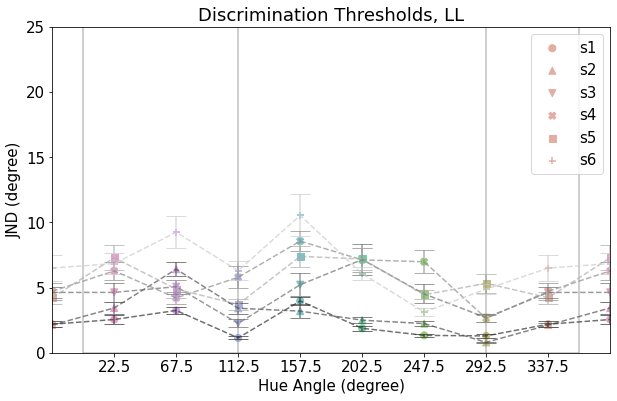

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


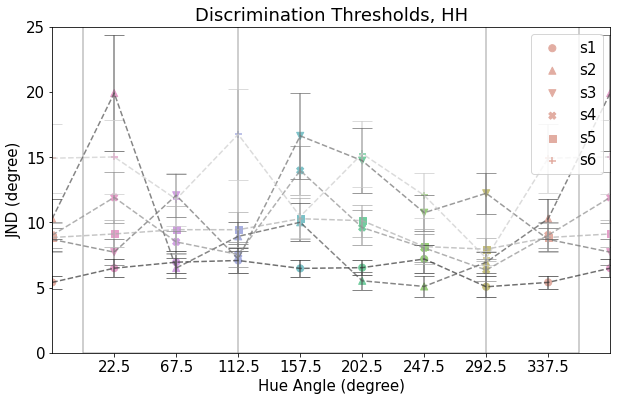

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


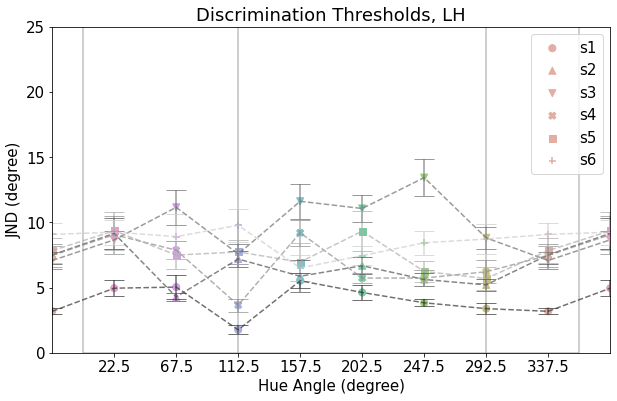

In [299]:
plot_JND(fit_plt, 'LL')
plot_JND(fit_plt, 'HH')
plot_JND(fit_plt, 'LH')

## Plot PSE (LH)

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


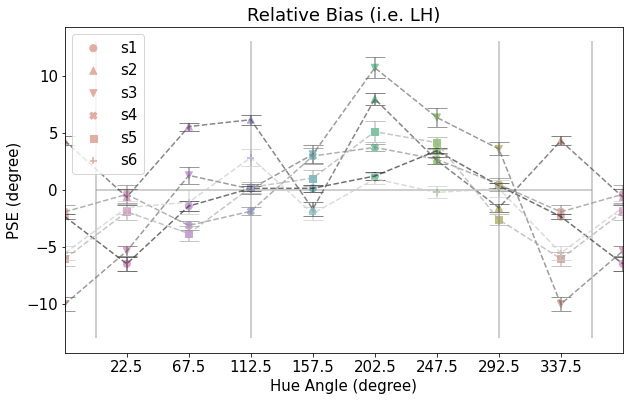

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


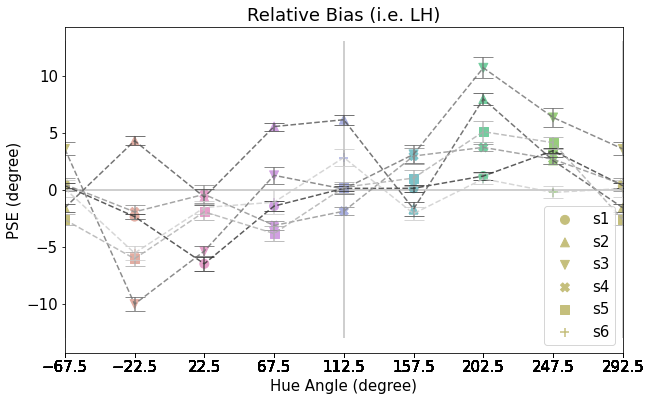

In [300]:
plot_PSE(fit_plt)
plot_PSE_oblique(fit)

## for manuscript: Descriptive Results of JNDs and PSEs

In [3]:
fit = pd.read_csv('data_analysis/pf_estimates/all_estimates.csv')
fit.head()

Unnamed: 0  Hue Angle       PSE        JND   PSE_err   JND_err condition  \
0           8       22.5 -0.613446   6.485856  0.376390  0.708687        HH   
1           8       22.5 -1.631312  19.905306  1.737019  4.466863        HH   
2           8       22.5 -1.773512   7.714372  0.590606  1.010489        HH   
3           8       22.5  0.428000  11.914025  0.944829  1.954205        HH   
4           8       22.5  0.000231   9.110568  0.551214  1.031183        HH   

  subject  trialN  
0      s1     240  
1      s2     240  
2      s3     240  
3      s4     240  
4      s5     240

In [16]:
# check: minima around 112.5 ad 292.5?

# two minima: 25% are at 112.5, 41.67% are at 292.5, 25% at 292.5 +/- 45, 8.33% at 112.5 +/- 45
ll_minima = fit.query("condition == 'LL'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').head(2)
ll_minima['loc'] = ll_minima['Hue Angle'].apply(lambda x: 1 if abs(x-112.5)<=45 else (2 if abs(x-292.5)<=45 else 0))
print(ll_minima)
print(ll_minima.groupby('loc')['Hue Angle'].agg(['mean', 'std']))

# 83% are near 112.5
hh_minima = fit.query("condition == 'HH'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').head(2)
hh_minima['loc'] = hh_minima['Hue Angle'].apply(lambda x: 1 if abs(x-112.5)<=45 else (2 if abs(x-292.5)<=45 else 0))
print(hh_minima)


    subject  Hue Angle       JND  loc
48       s1      112.5  1.140785    1
120      s1      292.5  1.294054    2
121      s2      292.5  0.800887    2
139      s2      337.5  2.125100    2
50       s3      112.5  2.253894    1
122      s3      292.5  2.691722    2
123      s4      292.5  2.634076    2
33       s4       67.5  4.209439    1
52       s5      112.5  3.707772    1
142      s5      337.5  4.221384    2
107      s6      247.5  3.127355    2
125      s6      292.5  4.880494    2
        mean        std
loc                    
1    101.250  22.500000
2    298.125  28.839148
    subject  Hue Angle        JND  loc
108      s1      292.5   5.060342    2
126      s1      337.5   5.396385    2
91       s2      247.5   5.086411    2
73       s2      202.5   5.517638    0
38       s3      112.5   7.194431    1
2        s3       22.5   7.714372    0
111      s4      292.5   6.344322    2
39       s4      112.5   7.534012    1
112      s5      292.5   7.941660    2
94       s5      247

In [6]:
(112.5+112.5+67.5)/3

97.5

In [15]:
# from scipy.stats import circmean
# np.rad2deg(circmean(fit.query("condition == 'LL'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').first(1)['Hue Angle'].agg(np.deg2rad)))


179.99999999999997

In [4]:
# 11/12% 
print(fit.query("condition == 'LH'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').head(2))


    subject  Hue Angle       JND
42       s1      112.5  1.758139
132      s1      337.5  3.181247
25       s2       67.5  4.285199
115      s2      292.5  5.206293
134      s3      337.5  7.076236
44       s3      112.5  7.575492
45       s4      112.5  3.655692
99       s4      247.5  5.729368
118      s5      292.5  5.694142
100      s5      247.5  6.236665
65       s6      157.5  6.505757
83       s6      202.5  7.448481


In [18]:
# check: maximal around 22.5 ad 202.5? (67.5, 337.5, 157.5, 247.5)

# 2/12 near 22.5, 2/12 near 202.5, 3/12 near 22.5+/-45, 5 near 202.5 +/- 45
ll_maxima = fit.query("condition == 'LL'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').tail(2)
ll_maxima['loc'] = ll_maxima['Hue Angle'].apply(lambda x: 1 if abs(x-22.5)<=45 else (2 if abs(x-202.5)<=45 else 0))
print(ll_maxima)
print(ll_maxima.groupby('loc')['Hue Angle'].agg(['mean', 'std']))

print(fit.query("condition == 'HH'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').tail(2))

   subject  Hue Angle        JND  loc
30      s1       67.5   3.246795    1
66      s1      157.5   3.968864    2
13      s2       22.5   3.437623    1
31      s2       67.5   6.410710    1
68      s3      157.5   5.216806    2
86      s3      202.5   7.146821    2
87      s4      202.5   7.122724    2
69      s4      157.5   8.561367    2
16      s5       22.5   7.285762    1
70      s5      157.5   7.390340    2
35      s6       67.5   9.241518    1
71      s6      157.5  10.533777    2
           mean        std
loc                       
1     49.500000  24.647515
2    170.357143  21.957752
    subject  Hue Angle        JND
36       s1      112.5   7.074807
90       s1      247.5   7.189138
127      s2      337.5  10.276999
1        s2       22.5  19.905306
74       s3      202.5  14.728103
56       s3      157.5  16.628685
3        s4       22.5  11.914025
57       s4      157.5  13.976935
76       s5      202.5  10.131143
58       s5      157.5  10.276155
77       s6      202.5  

In [49]:
print(fit.query("condition == 'LH'")[['subject', 'Hue Angle', 'JND']].sort_values(by=['subject', 'JND'], ascending=True).groupby('subject').tail(2))

    subject  Hue Angle        JND
24       s1       67.5   5.037181
60       s1      157.5   5.519278
133      s2      337.5   7.503054
7        s2       22.5   9.149964
62       s3      157.5  11.613355
98       s3      247.5  13.427736
9        s4       22.5   9.053354
63       s4      157.5   9.200685
82       s5      202.5   9.326060
10       s5       22.5   9.353379
11       s6       22.5   9.250171
47       s6      112.5   9.772647


In [15]:
import pingouin as pg
pg.rm_anova(fit[(fit['Hue Angle']==112.5) | (fit['Hue Angle']==292.5)], dv='JND', within=['Hue Angle','condition'], subject='subject')


Source          SS  ddof1  ddof2         MS          F  \
0              Hue Angle    6.902522      1      5   6.902522   1.053762   
1              condition  163.553239      2     10  81.776620  36.505884   
2  Hue Angle * condition    5.496979      2     10   2.748489   0.703549   

      p-unc  p-GG-corr       np2       eps  
0  0.351716   0.351716  0.174067  1.000000  
1  0.000025   0.000648  0.879535  0.617925  
2  0.517755   0.498279  0.123353  0.842280

In [60]:
fit.groupby(['subject', 'condition'])['PSE'].agg(['max', 'min'])


max        min
subject condition                      
s1      HH          0.725223  -0.613446
        LH          3.420589  -6.495166
        LL          0.704595  -0.185733
s2      HH          1.629061  -1.631312
        LH          7.956575  -1.691044
        LL          0.304599  -0.238481
s3      HH          1.262696  -1.773512
        LH         10.691646 -10.029591
        LL          0.608366  -0.983582
s4      HH          1.441322  -0.598417
        LH          3.712572  -3.133805
        LL          0.417059  -1.029825
s5      HH          1.021009  -0.888342
        LH          5.088307  -6.049729
        LL          1.635885  -0.693067
s6      HH          1.195879  -1.848193
        LH          2.822796  -5.557894
        LL          0.576076  -0.527151

In [ ]:
fit.query("condition == 'LH'").groupby(['subject'])['PSE'].min().agg(['mean', 'std'])
fit.query("condition == 'LH'").groupby(['subject'])['PSE'].max().agg(['mean', 'std'])

In [29]:
fit_lh = fit.query("condition == 'LH'")

positive_PSE = fit_lh.loc[fit_lh['PSE']>=0].groupby(['subject', 'Hue Angle'])['PSE'].count().reset_index()
print(f"number of postive PSE: {len(positive_PSE)}")
print("propotion that positive pse falls into [112.5 ,292.5]:")
print(positive_PSE['Hue Angle'].apply(lambda x: True if x>= 112.5 and x <= 292.5 else False).sum()/len(positive_PSE))

negative_PSE = fit_lh.loc[fit_lh['PSE']<=0].groupby(['subject', 'Hue Angle'])['PSE'].count().reset_index()
print(f"number of negative PSE: {len(negative_PSE)}")
print("propotion that negative pse falls out of [112.5 ,292.5]:")
print(negative_PSE['Hue Angle'].apply(lambda x: True if x<= 112.5 or x >= 292.5 else False).sum()/len(negative_PSE))


number of postive PSE: 27
propotion that positive pse falls into [112.5 ,292.5]:
0.8888888888888888
number of negative PSE: 21
propotion that negative pse falls out of [112.5 ,292.5]:
0.8571428571428571


In [94]:
fit_lh.loc[fit_lh['PSE']<0].groupby(['subject', 'Hue Angle'])['PSE'].count()

subject  Hue Angle
s1       22.5         1
         67.5         1
         337.5        1
s2       22.5         1
         157.5        1
         292.5        1
s3       22.5         1
         337.5        1
s4       22.5         1
         67.5         1
         112.5        1
         337.5        1
s5       22.5         1
         67.5         1
         292.5        1
         337.5        1
s6       22.5         1
         67.5         1
         157.5        1
         247.5        1
         337.5        1
Name: PSE, dtype: int64

In [58]:
pse_range = fit.groupby(['subject']).apply(lambda x: x.PSE.max() - x.PSE.min())
pse_range
pse_range.values.mean() 
pse_range.values.std()


subject
s1     9.915755
s2     9.647619
s3    20.721237
s4     6.846377
s5    11.138036
s6     8.380690
dtype: float64

In [89]:
avg_fit = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv')
avg_fit['PSE_abs'] = avg_fit.PSE.abs()
avg_fit.query("condition == 'LH'")#.loc[avg_fit.groupby('condition')['PSE_abs'].idxmin()]

Unnamed: 0  Hue Angle       PSE       JND   PSE_err   JND_err condition  \
16          16       22.5 -4.156144  7.649972  0.435972  0.697110        LH   
17          17       67.5  0.465497  9.331943  0.674285  1.384447        LH   
18          18      112.5  1.379254  7.165280  0.452378  0.889735        LH   
19          19      157.5  0.434572  8.820182  0.441789  0.849325        LH   
20          20      202.5  5.764945  7.623779  0.436990  0.577590        LH   
21          21      247.5  3.134222  5.572733  0.212149  0.318141        LH   
22          22      292.5 -0.412382  6.412355  0.267676  0.463789        LH   
23          23      337.5 -4.307909  6.286296  0.490782  0.689386        LH   

   subject  trialN   PSE_abs  
16    sAVG    1440  4.156144  
17    sAVG    1440  0.465497  
18    sAVG    1440  1.379254  
19    sAVG    1440  0.434572  
20    sAVG    1440  5.764945  
21    sAVG    1440  3.134222  
22    sAVG    1440  0.412382  
23    sAVG    1440  4.307909

## Average of subjects

#### Simply average subjects' estimates


In [302]:
n = len(fit['subject'].unique())
simple_avg_fit = pd.merge(fit.groupby(['Hue Angle', 'condition'])[['JND', 'PSE']].apply(np.mean).reset_index(),
fit.groupby(['Hue Angle', 'condition'])[['JND', 'PSE']].apply(np.std).reset_index(), on=['Hue Angle', 'condition'])
simple_avg_fit.columns = ['Hue Angle', 'condition', 'JND', 'PSE', 'JND_sd', 'PSE_sd']
simple_avg_fit['JND_err'] = simple_avg_fit['JND_sd'] / np.sqrt(n)
simple_avg_fit['PSE_err'] = simple_avg_fit['PSE_sd'] / np.sqrt(n)
simple_avg_fit.to_csv('data_analysis/pf_estimates/simple_avg_estimates.csv')


#### Fit pooled raw data to PF

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

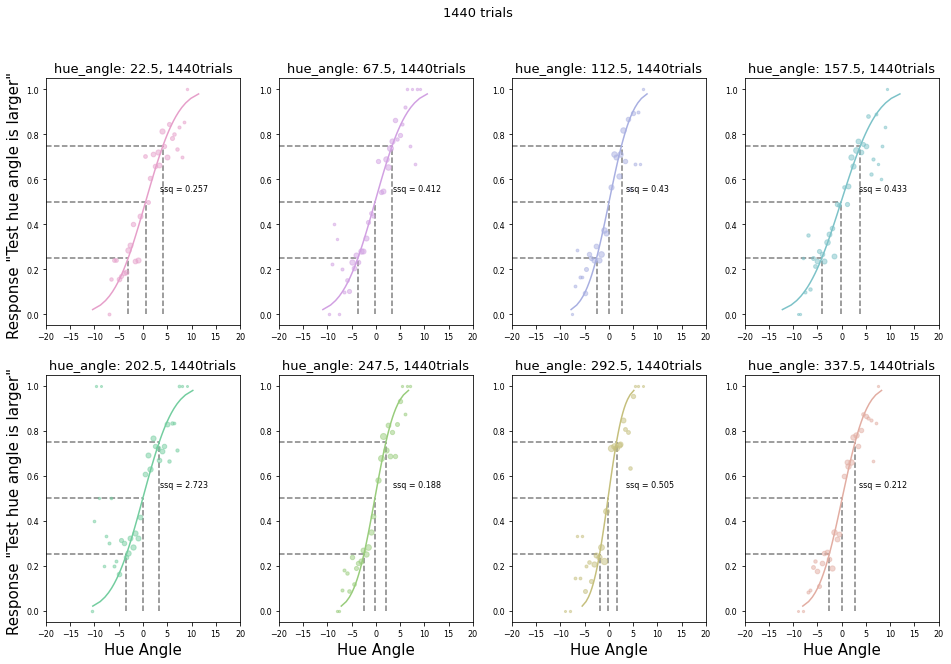

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

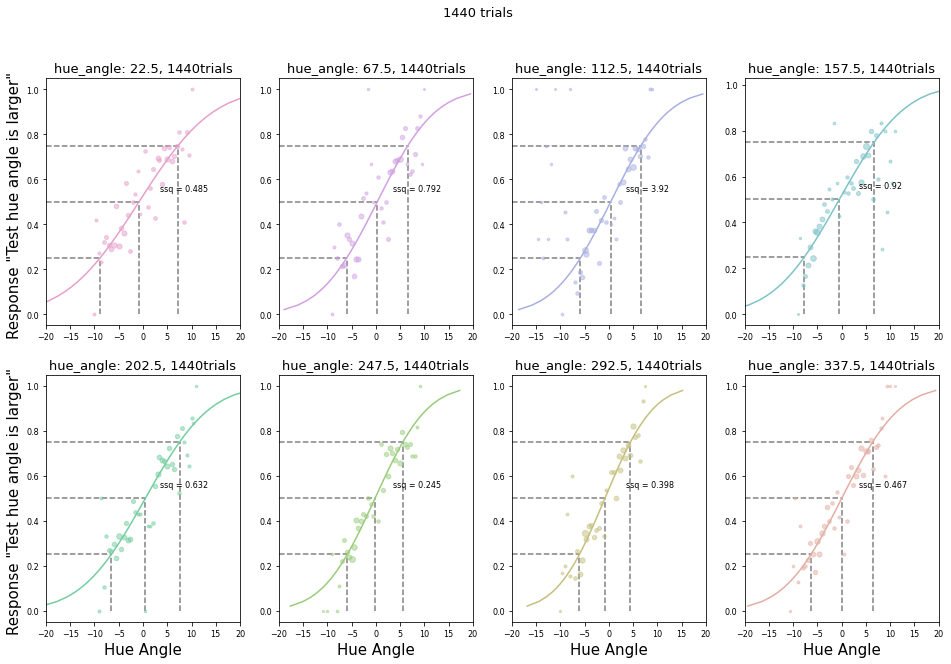

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

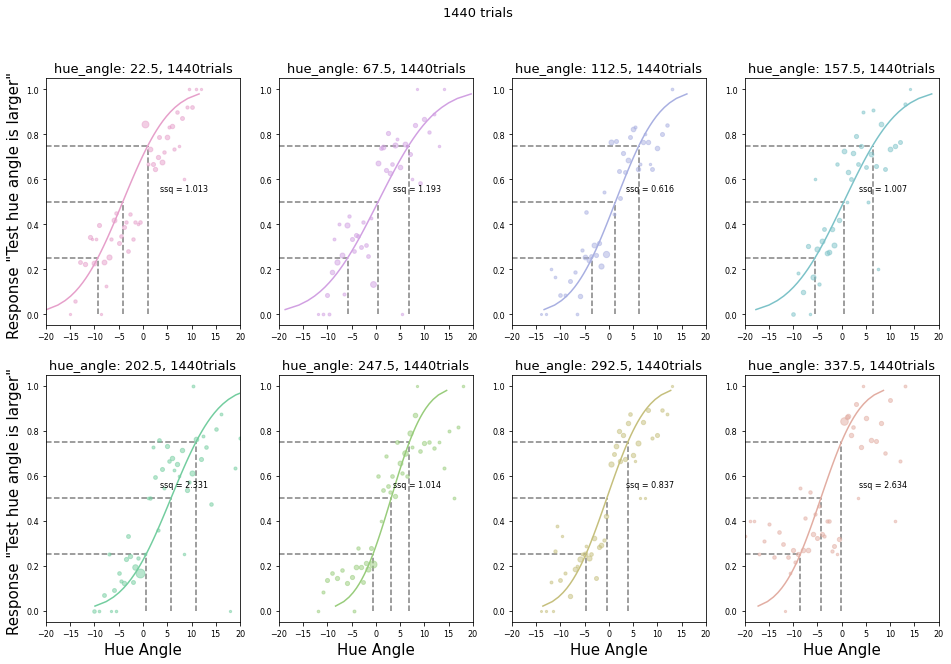

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


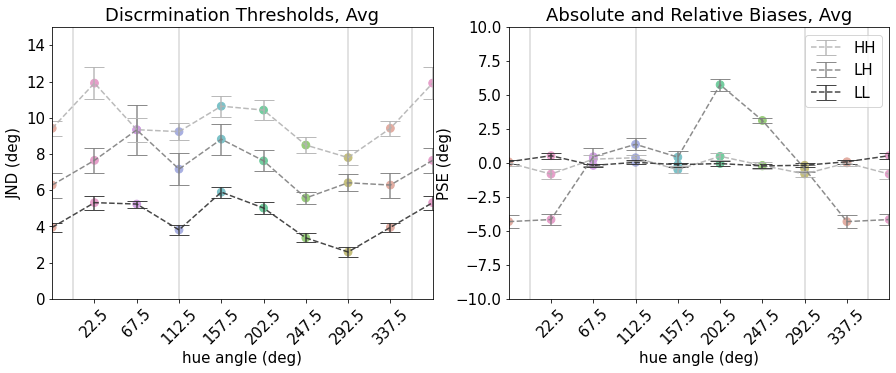

In [324]:
# Fit PF
sAVG_ll, sAVG_hh, sAVG_lh = dat.query("condition == 'LL'"), dat.query("condition == 'HH'"), dat.query("condition == 'LH'")
sAVG_ll_FitPf, sAVG_hh_FitPf, sAVG_lh_FitPf = FitPf(sAVG_ll), FitPf(sAVG_hh), FitPf(sAVG_lh)
sAVG_ll_FitPf.plot_pf_curve(save_pdf='PF_curves/sAVG_LL')
sAVG_hh_FitPf.plot_pf_curve(save_pdf='PF_curves/sAVG_HH')
sAVG_lh_FitPf.plot_pf_curve(save_pdf='PF_curves/sAVG_LH')

avg_fit = comp_within_sub('Avg', [sAVG_ll_FitPf.fit(), 
                                    sAVG_hh_FitPf.fit(), 
                                    sAVG_lh_FitPf.fit()], 
                                    ['LL', 'HH', 'LH'], 
                                    plots=True)

avg_fit.to_csv('data_analysis/pf_estimates/avg_estimates.csv')

### All-in-one plot

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


[]

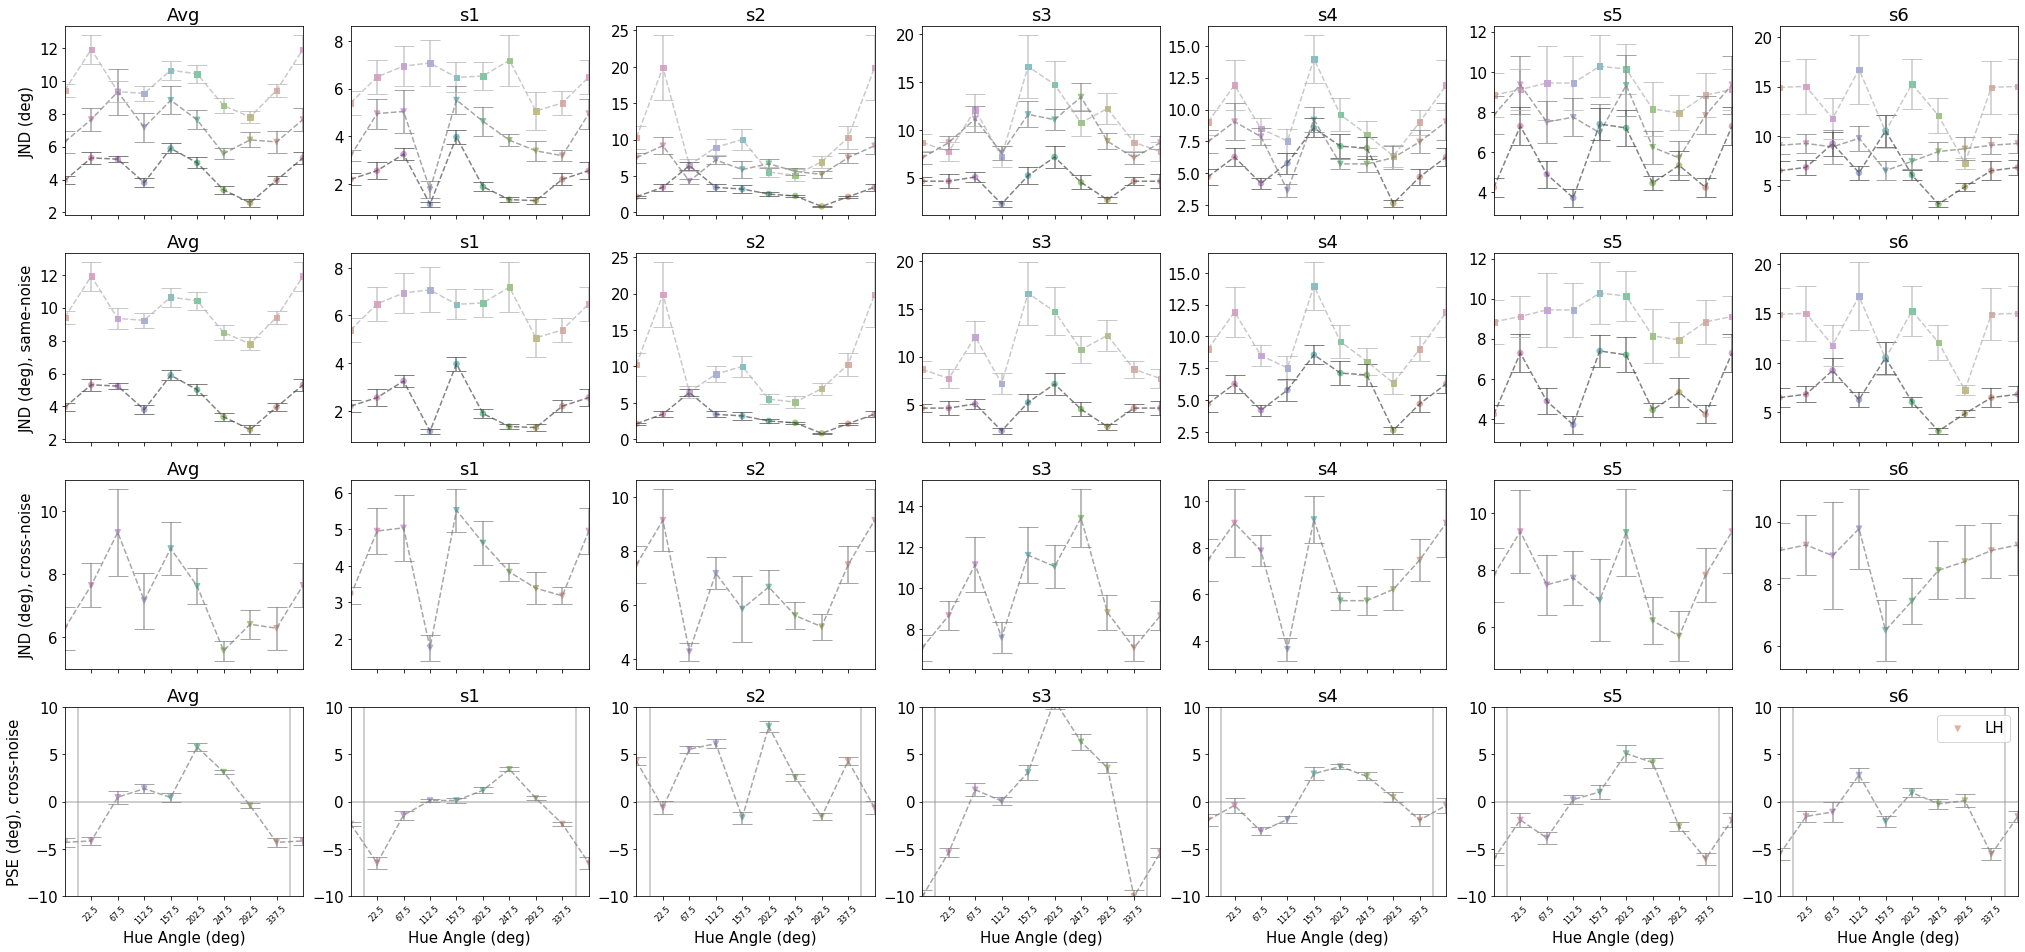

In [304]:
#Merge average fit to subject fits 
fit_plt_all = pd.concat([fit_plt, rep_end(avg_fit)]).sort_values(['Hue Angle', 'condition', 'subject'])

sub_fits = [x for _, x in fit_plt_all.groupby("subject")]
n_sub = len(sub_fits)

fig, ax = plt.subplots(figsize=(5*n_sub, 16), nrows=4, ncols=n_sub, sharex='col', sharey=False)

first_x = 22.5
x_ticks = np.linspace(0 + first_x, 360 + first_x, 8, endpoint=False)
linecolors =  {'LL': [.3, .3, .3], 'HH': [.7, .7, .7], 'LH': [.5, .5, .5]}
markers = {'LL': 'o', 'HH': 's', 'LH': 'v'}
marker_color = color4plot(fit_plt['Hue Angle'].unique())
marker_size = 30

for idx, sfit in enumerate(sub_fits):
    sub = sfit['subject'].unique()[0]

    # Plot JND, all conditions
    ax[0, idx].set_title(sub)
    for key, grp in sfit.groupby('condition'):
        ax[0, idx].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'], 
                            c=linecolors[key], linestyle='dashed', alpha=0.7, capsize=10)
        ax[0, idx].scatter(x=grp['Hue Angle'], y=grp['JND'], 
                           c=marker_color, s=marker_size, marker=markers[key], label=key)
    # ax[0, 0].set_yscale('log') 
    # ax[0, idx].set_ylim([10**(-1), 10**1.5])
    ax[0, 0].set_ylabel('JND (deg)')
    
    sfit_LH = sfit.query("condition=='LH'")

    # Plot JND, same-noise
    ax[1, idx].set_title(sub)
    for key, grp in sfit.query("condition=='LL' or condition=='HH'").groupby('condition'):
        ax[1, idx].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'], 
                            c=linecolors[key], linestyle='dashed', alpha=0.7, capsize=10)
        ax[1, idx].scatter(x=grp['Hue Angle'], y=grp['JND'], 
                           c=marker_color, s=marker_size, marker=markers[key], label=key)
    # ax[1, 0].set_yscale('log') 
    # ax[1, idx].set_ylim([10**(0), 10**1.5])
    ax[1, 0].set_ylabel('JND (deg), same-noise')
    
    sfit_LH = sfit.query("condition=='LH'")

    # Plot JND, cross-noise
    ax[2, idx].set_title(sub)
    ax[2, idx].errorbar(x=sfit_LH['Hue Angle'], y=sfit_LH['JND'], yerr=sfit_LH['JND_err'], 
                        c=linecolors['LH'], linestyle='dashed', alpha=0.7, capsize=10)
    ax[2, idx].scatter(x=sfit_LH['Hue Angle'], y=sfit_LH['JND'], 
                      c=marker_color, s=marker_size, marker=markers['LH'], label='LH')
    # ax[2, 0].set_yscale('log')       
    # ax[2, idx].set_ylim([10**(-1), 10**1.5])
    ax[2, 0].set_ylabel('JND (deg), cross-noise')
    
    # Plot PSE, cross-noise
    ax[3, idx].set_title(sub)
    ax[3, idx].errorbar(x=sfit_LH['Hue Angle'], y=sfit_LH['PSE'], yerr=sfit_LH['PSE_err'], 
                        c=linecolors['LH'], linestyle='dashed', alpha=0.7, capsize=10)
    ax[3, idx].scatter(x=sfit_LH['Hue Angle'], y=sfit_LH['PSE'], 
                      c=marker_color, s=marker_size, marker=markers['LH'], label='LH')
    ax[3, idx].set_ylim([-10, 10])
    ax[3, 0].set_ylabel('PSE (deg), cross-noise')
    ax[3, idx].set_xlim([-first_x, 360 + first_x])
    ax[3, idx].set_xticks(x_ticks)
    ax[3, idx].set_xticklabels(x_ticks, rotation=45, fontsize=8)

    ax[3, idx].set_xlabel('Hue Angle (deg)')

    ax[3, idx].hlines(0, -first_x, 360 + first_x, colors='grey', alpha=0.5)
    ax[3, idx].vlines(0, -10, 10, colors='grey', alpha=0.5)
    ax[3, idx].vlines(360, -10, 10, colors='grey', alpha=0.5)


plt.legend()
plt.plot()



### Statistical tests


In [289]:


# Stats. on JNDs

from scipy import stats
JND_LL = fit.query("condition=='LL'")['JND'].values
JND_HH = fit.query("condition=='HH'")['JND'].values
JND_LH = fit.query("condition=='LH'")['JND'].values

# Compare JNDs with Wilcoxon signed-rank test (single sided)
stat_l_h, p_l_h = stats.wilcoxon(JND_LL, JND_HH, alternative='less') 
# print(stat_l_h, p_l_h) 
stat_l_lh, p_l_lh = stats.wilcoxon(JND_LL, JND_LH, alternative='less')  
# print(stat_l_lh, p_l_lh)
stat_h_lh, p_h_lh = stats.wilcoxon(JND_HH, JND_LH, alternative='greater')  
# print(stat_h_lh, p_h_lh)

print("Across subjects and hues: ")

# The percentage of whether JNDs were less or greater...

print(f"Stats.1: \
{sum(JND_LL < JND_HH)/len(JND_HH) * 100} % of JNDs were higher for the HH than LL conditions, \
sign test p = {np.round(p_l_h, 5)}.")

print(f"Stats.2: \
{sum(JND_LL < JND_LH)/len(JND_LH) * 100} % of JNDs were higher for the LH than LL conditions, \
sign test p = {np.round(p_l_lh, 5)}.")

print(f"Stats.3: \
{sum(JND_LH < JND_HH)/len(JND_HH) * 100} % of JNDs were higher for the HH than LH conditions, \
sign test p = {np.round(p_h_lh, 5)}.")

Across subjects and hues: 
Stats.1: 97.91666666666666 % of JNDs were higher for the HH than LL conditions, sign test p = 0.0.
Stats.2: 85.41666666666666 % of JNDs were higher for the LH than LL conditions, sign test p = 0.0.
Stats.3: 87.5 % of JNDs were higher for the HH than LH conditions, sign test p = 0.0.


### Compare averaging methods
simple average vs. pool and fit, whether they are siginificantly different?

In [34]:
simple_avg_fit = pd.read_csv("data_analysis/pf_estimates/simple_avg_estimates.csv").sort_values(by=['Hue Angle', 'condition'])
avg_fit = pd.read_csv("data_analysis/pf_estimates/avg_estimates.csv").sort_values(by=['Hue Angle', 'condition'])

In [21]:
simple_avg_fit.head()

Unnamed: 0  Hue Angle condition        JND       PSE    JND_sd    PSE_sd  \
0           0       22.5        HH  11.690497 -0.668363  4.621057  0.802318   
1           1       22.5        LH   8.402642 -2.737937  1.558776  2.342446   
2           2       22.5        LL   5.169722  0.372848  1.761836  0.774356   
3           3       67.5        HH   9.203937  0.423400  2.152105  0.593846   
4           4       67.5        LH   7.455959 -0.450138  2.303502  3.132613   

    JND_err   PSE_err  
0  1.886539  0.327545  
1  0.636368  0.956300  
2  0.719266  0.316130  
3  0.878593  0.242436  
4  0.940401  1.278884

In [22]:
avg_fit.head()

Unnamed: 0  Hue Angle       PSE        JND   PSE_err   JND_err condition  \
8            8       22.5 -0.809920  11.911836  0.372401  0.869758        HH   
16          16       22.5 -4.156144   7.649972  0.435972  0.697110        LH   
0            0       22.5  0.541347   5.316100  0.211905  0.379231        LL   
9            9       67.5  0.287445   9.342150  0.328276  0.657461        HH   
17          17       67.5  0.465497   9.331943  0.674285  1.384447        LH   

   subject  trialN  
8     sAVG    1440  
16    sAVG    1440  
0     sAVG    1440  
9     sAVG    1440  
17    sAVG    1440

In [51]:
avg_fit.sort_values(by=['condition', 'JND'], ascending=True).groupby('condition').head(3)

Unnamed: 0  Hue Angle       PSE       JND   PSE_err   JND_err condition  \
14          14      292.5 -0.798646  7.801878  0.205053  0.392741        HH   
13          13      247.5 -0.173979  8.493427  0.233074  0.462584        HH   
10          10      112.5  0.391896  9.233875  0.220262  0.451093        HH   
21          21      247.5  3.134222  5.572733  0.212149  0.318141        LH   
23          23      337.5 -4.307909  6.286296  0.490782  0.689386        LH   
22          22      292.5 -0.412382  6.412355  0.267676  0.463789        LH   
6            6      292.5 -0.160575  2.591408  0.135858  0.252269        LL   
5            5      247.5 -0.210853  3.371025  0.133478  0.249800        LL   
2            2      112.5  0.052990  3.811168  0.145221  0.277004        LL   

   subject  trialN  
14    sAVG    1440  
13    sAVG    1440  
10    sAVG    1440  
21    sAVG    1440  
23    sAVG    1440  
22    sAVG    1440  
6     sAVG    1440  
5     sAVG    1440  
2     sAVG    1440

In [23]:
from scipy import stats
stats.wilcoxon(simple_avg_fit.JND.values, avg_fit.JND.values) 


WilcoxonResult(statistic=122.0, pvalue=0.4389305114746094)

In [24]:
stats.wilcoxon(simple_avg_fit.PSE.values, avg_fit.PSE.values) 

WilcoxonResult(statistic=135.0, pvalue=0.6839864253997803)

In [25]:
stats.wilcoxon(simple_avg_fit.query("condition == 'LH'").JND.values, avg_fit.query("condition == 'LH'").JND.values) 

WilcoxonResult(statistic=14.0, pvalue=0.640625)

In [26]:
stats.wilcoxon(simple_avg_fit.query("condition == 'LH'").PSE.values, avg_fit.query("condition == 'LH'").PSE.values) 

WilcoxonResult(statistic=16.0, pvalue=0.84375)

In [30]:
# for the particular point at hue angle = 157.5
sel_hue = simple_avg_fit.loc[(simple_avg_fit['Hue Angle']==157.5) & (simple_avg_fit.condition == 'LH')]

# 95% CI:
[sel_hue.PSE - 1.96 * sel_hue.PSE_err, sel_hue.PSE + 1.96 * sel_hue.PSE_err]

[10   -1.055338
 dtype: float64,
 10    2.193385
 dtype: float64]

In [33]:
# the PSE of average fit falls into this interval 
avg_fit.loc[(avg_fit['Hue Angle']==157.5) & (avg_fit.condition == 'LH')].PSE.values

array([0.43457208])

# Suppl. Results: Preliminary/Pilot data
The preliminary data was collected from the same paradigm and procedures as the present data. The only difference is the distribution of the stimulus noise: noise were from a Gaussian distribution in the pilot study but from an uniform distribution in the present study, to minimize the influence of extreme values in the Gaussian distribution.

Full documentation and results of the pilot study can be found in `preliminary_data_analysis.ipynb`.

The within-subject results were consistent between the two versions.
In the early phase of analysis, the present and preliminary data were combined to have some insights before completing the data collection.

In [93]:
# Load preliminary psychophysical data
pre_dat = pd.read_csv('data/pre_sel_data.csv').query("Subject == 'tw'")
pre_dat = pre_dat.replace({'Subject': {'tw': 's3'}})
pre_dat = pre_dat.replace({'Condition': {'L-L': 'LL', 'H-H': 'HH', 'L-H': 'LH'}})
pre_dat = pre_dat.drop(columns=['Unnamed: 0'])
# pre_dat.head()

# Load estimates from preliminary PF estimates
pre_fit = pd.read_csv('data/preliminary_estimates.csv').query("subject == 'tw'")
pre_fit = pre_fit.replace({'subject': {'tw': 's3'}})
pre_fit = pre_fit.replace({'condition': {'L-L': 'LL', 'H-H': 'HH', 'L-H': 'LH'}})
pre_fit = pre_fit.drop(columns=['Unnamed: 0'])
# pre_fit.head()



## Present + preliminary data

In [292]:
all_fit = pd.concat([pre_fit, s1_fit, s2_fit, s4_fit, s5_fit, s6_fit]).sort_values(['Hue Angle', 'condition', 'subject'])
all_fit_plt = rep_end(all_fit)

### Plot JND

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


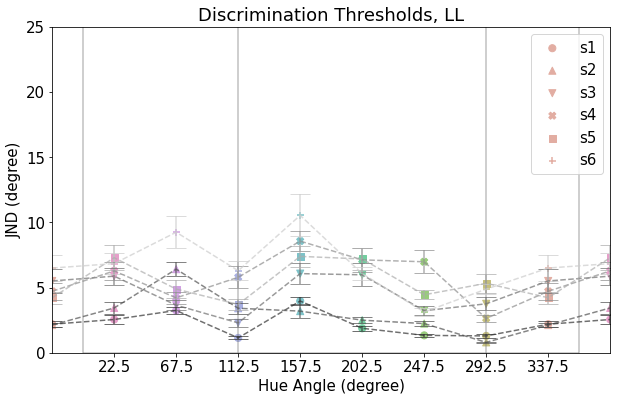

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


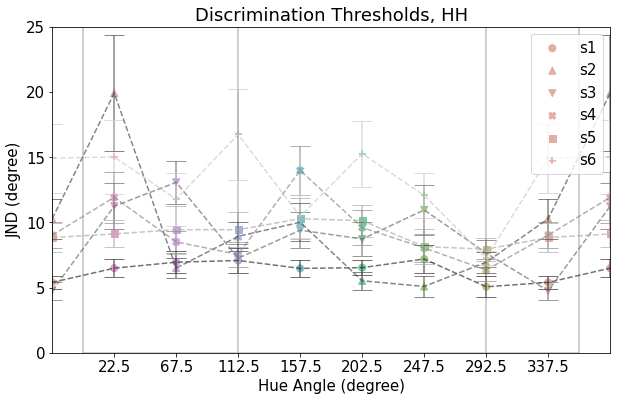

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


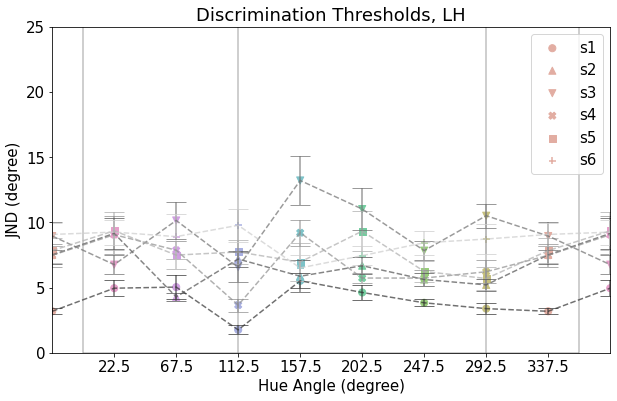

In [293]:
plot_JND(all_fit_plt, 'LL')
plot_JND(all_fit_plt, 'HH')
plot_JND(all_fit_plt, 'LH')

### Plot PSE

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


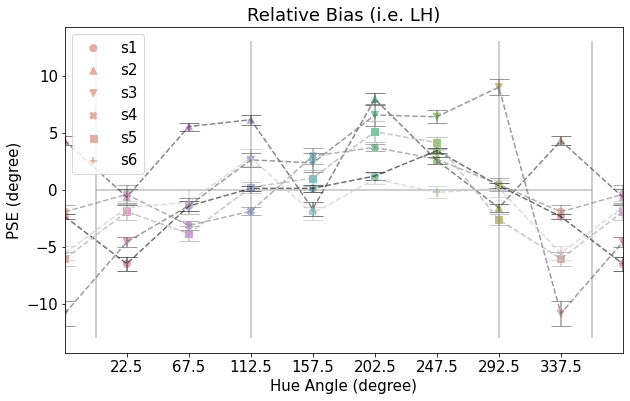

In [294]:
plot_PSE(all_fit_plt)

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


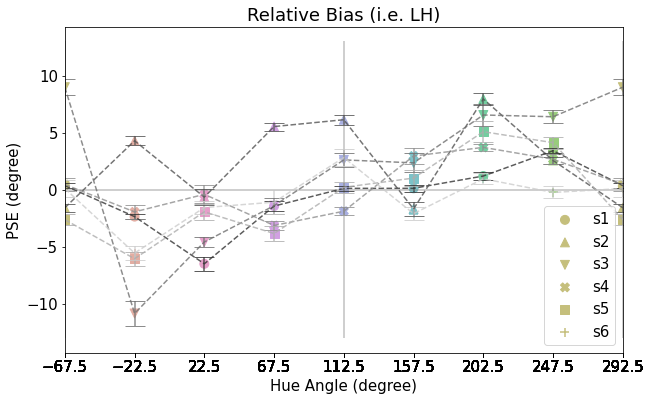

In [295]:
plot_PSE_oblique(all_fit)

### Average across subjects

In [98]:
#Combine present and preliminary data
pre_dat = pre_dat.rename(columns={'Condition': 'condition', 
                                'Subject': 'subject', 
                                'Hue Angle': 'standard_stim',
                                'All Intensities':'actual_intensity', 
                                'All Responses': 'judge',
                                'Reaction Time': 'react_time'})

all_data = pd.concat([dat, pre_dat])

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


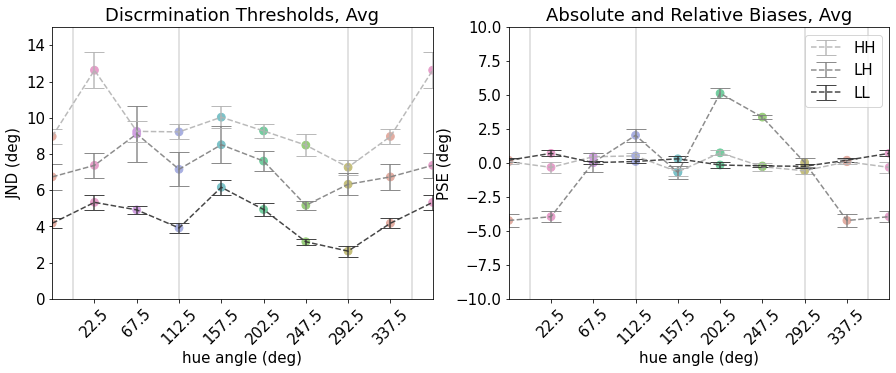

In [115]:
# Fit PF
# FitPf(all_data.query("condition == 'LL'")).plot_pf_curve()
# FitPf(all_data.query("condition == 'HH'")).plot_pf_curve()
# FitPf(all_data.query("condition == 'LH'")).plot_pf_curve()

all_avg_fit = comp_within_sub('Avg', [FitPf(all_data.query("condition == 'LL'")).fit(), 
                        FitPf(all_data.query("condition == 'HH'")).fit(), 
                        FitPf(all_data.query("condition == 'LH'")).fit()], 
                        ['LL', 'HH', 'LH'], 
                        plots=True)

### All-in-one plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[]

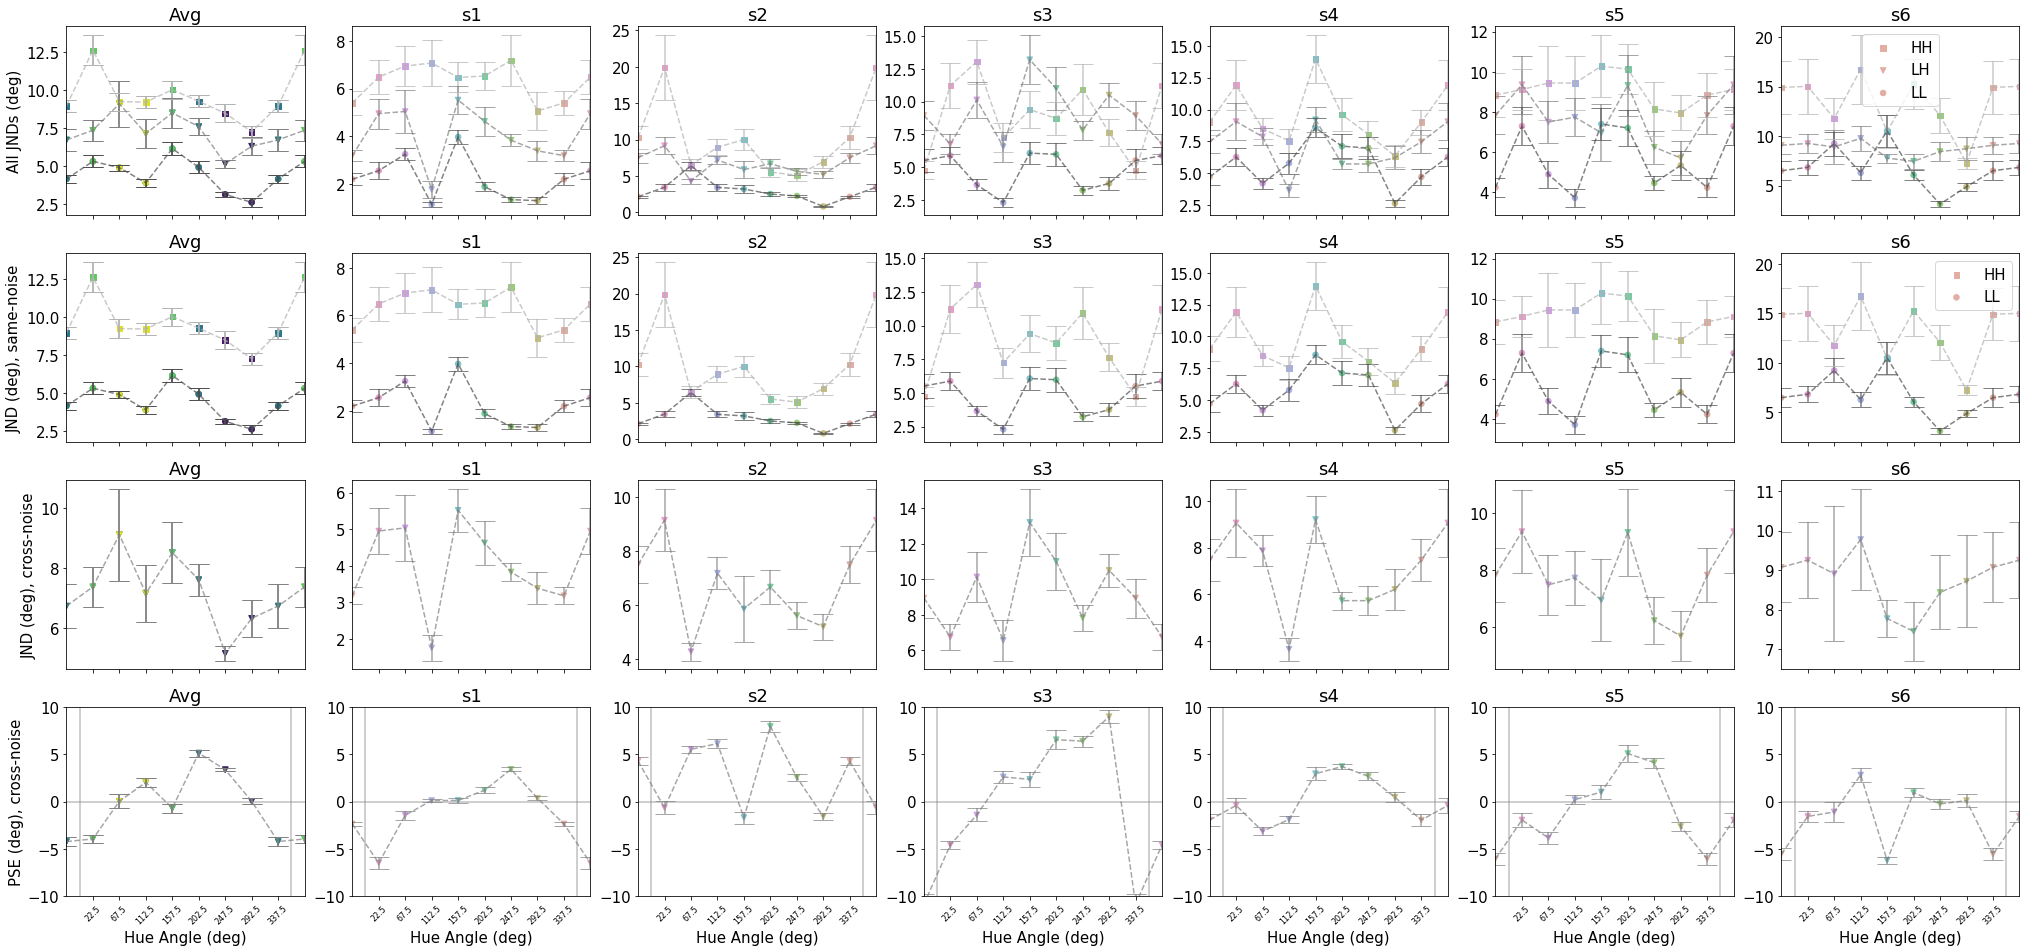

In [116]:
all_fit_plt = pd.concat([all_fit_plt, rep_end(all_avg_fit)]).sort_values(['Hue Angle', 'condition', 'subject'])

sub_fits = [x for _, x in all_fit_plt.groupby("subject")]
n_sub = len(sub_fits)

fig, ax = plt.subplots(figsize=(5*n_sub, 16), nrows=4, ncols=n_sub, sharex='col')

first_x = 22.5
x_ticks = np.linspace(0 + first_x, 360 + first_x, 8, endpoint=False)
linecolors =  {'LL': [.3, .3, .3], 'HH': [.7, .7, .7], 'LH': [.5, .5, .5]}
markers = {'LL': 'o', 'HH': 's', 'LH': 'v'}
marker_color = color4plot(all_fit_plt['Hue Angle'].unique())
marker_size = 30

for idx, sfit in enumerate(sub_fits):
    sub = sfit['subject'].unique()[0]

    # Plot JND, all conditions
    ax[0, idx].set_title(sub)
    for key, grp in sfit.groupby('condition'):
        ax[0, idx].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'], 
                            c=linecolors[key], linestyle='dashed', alpha=0.7, capsize=10)
        ax[0, idx].scatter(x=grp['Hue Angle'], y=grp['JND'], 
                           c=marker_color, s=marker_size, marker=markers[key], label=key)
    # ax[0, idx].set_ylim([0, 25])
    # ax[0, 0].set_yscale('log') 
    # ax[0, idx].set_ylim([10**(0.05), 10**1.6])
    ax[0, 0].set_ylabel('All JNDs (deg)')
    ax[0, n_sub-1].legend()

    
    sfit_LH = sfit.query("condition=='LH'")

    # Plot JND, same-noise
    ax[1, idx].set_title(sub)
    for key, grp in sfit.query("condition=='LL' or condition=='HH'").groupby('condition'):
        ax[1, idx].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'], 
                            c=linecolors[key], linestyle='dashed', alpha=0.7, capsize=10)
        ax[1, idx].scatter(x=grp['Hue Angle'], y=grp['JND'], 
                           c=marker_color, s=marker_size, marker=markers[key], label=key)
    # ax[1, 0].set_yscale('log') 
    # ax[1, idx].set_ylim([10**(0.05), 10**1.6])
    ax[1, 0].set_ylabel('JND (deg), same-noise')
    ax[1, n_sub-1].legend()

    
    sfit_LH = sfit.query("condition=='LH'")

    # Plot JND, cross-noise
    ax[2, idx].set_title(sub)
    ax[2, idx].errorbar(x=sfit_LH['Hue Angle'], y=sfit_LH['JND'], yerr=sfit_LH['JND_err'], 
                        c=linecolors['LH'], linestyle='dashed', alpha=0.7, capsize=10)
    ax[2, idx].scatter(x=sfit_LH['Hue Angle'], y=sfit_LH['JND'], 
                      c=marker_color, s=marker_size, marker=markers['LH'], label='LH')
    # ax[2, 0].set_yscale('log')       
    # ax[2, idx].set_ylim([10**(0.05), 10**1.6])
    ax[2, 0].set_ylabel('JND (deg), cross-noise')
    # ax[2, 0].legend()    

    # Plot PSE, cross-noise
    ax[3, idx].set_title(sub)
    ax[3, idx].errorbar(x=sfit_LH['Hue Angle'], y=sfit_LH['PSE'], yerr=sfit_LH['PSE_err'], 
                        c=linecolors['LH'], linestyle='dashed', alpha=0.7, capsize=10)
    ax[3, idx].scatter(x=sfit_LH['Hue Angle'], y=sfit_LH['PSE'], 
                      c=marker_color, s=marker_size, marker=markers['LH'], label='LH')
    ax[3, idx].set_ylim([-10, 10])
    ax[3, 0].set_ylabel('PSE (deg), cross-noise')
    # ax[3, 0].legend()
    ax[3, idx].set_xlim([-first_x, 360 + first_x])
    ax[3, idx].set_xticks(x_ticks)
    ax[3, idx].set_xticklabels(x_ticks, rotation=45, fontsize=8)
    ax[3, idx].set_xlabel('Hue Angle (deg)')

    ax[3, idx].hlines(0, -first_x, 360 + first_x, colors='grey', alpha=0.5)
    ax[3, idx].vlines(0, -10, 10, colors='grey', alpha=0.5)
    ax[3, idx].vlines(360, -10, 10, colors='grey', alpha=0.5)

plt.plot()



# Suppl. Test: whether the bias is derived from assymetric JNDs?

__Suspicion__: 

For a hue stimulus, if the discrimination is always better at its negative side than its positive side, would this leads to a positive bias?

Take s03 data as an example.

Separate plus and minus data, fit to PF separately and calculate the ratio of 75% threshold of minus and plus sides.  
Scale the original intensities by the ratio to compenstate the potential differences of discriminations between the plus and minus sides, and then fit the scaled data to PF, to test whether the relative bias is changed.

In [2]:
test_dat = pd.read_csv('data/s03/s3_data.csv')
test_fit = pd.read_csv('data_analysis/pf_estimates/s3_fit.csv')


In [3]:
test_dat.head()

Unnamed: 0  trial_index    stimulus  standard_stim  test_stim standard_xlim  \
0    trial_1            9  stimulus_3          202.5      197.5    [4.5, 1.5]   
1    trial_2           10  stimulus_2          202.5      207.5    [4.5, 1.5]   
2    trial_3           11  stimulus_0           22.5       27.5    [4.5, 1.5]   
3    trial_4           12  stimulus_1           22.5       17.5    [4.5, 1.5]   
4    trial_5           13  stimulus_1           22.5       19.5    [4.5, 1.5]   

      test_xlim  calculated_intensity  actual_intensity press_key  judge  \
0  [-4.5, -1.5]                  -5.0              -5.0    ['up']      1   
1  [-4.5, -1.5]                   5.0               5.0  ['down']      1   
2  [-4.5, -1.5]                   5.0               5.0  ['down']      1   
3  [-4.5, -1.5]                  -5.0              -5.0    ['up']      1   
4  [-4.5, -1.5]                  -3.0              -3.0  ['down']      0   

   react_time  trial_time_stamp     time_index  resp_as_larger condition  \
0    0.772522      1.625393e+09  20210704T1206               0        LL   
1    0.775504      1.625393e+09  20210704T1206               1        LL   
2    0.773758      1.625393e+09  20210704T1206               1        LL   
3    0.774607      1.625393e+09  20210704T1206               0        LL   
4    0.775280      1.625393e+09  20210704T1206               1        LL   

  subject  
0     s03  
1     s03  
2     s03  
3     s03  
4     s03

In [17]:
test_lh = test_dat[test_dat.condition=='LH']
test_ll = test_dat[test_dat.condition=='LL']

/Users/su/PhD-projects/colororder_v2/data_analysis/fit_pf_bayes.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  'standard_stim']  # to make the following fitting easier, create a new column of standard stimulus with sign labels
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/bayesfit/extractMetrics.py:92: RuntimeWarning: invalid value encountered in true_divide
  Deviance = 2*np.sum(n*y*np.log(y/p) + n*(1-y)*np.log((1-y)/(1-p)))
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/bayesfit/extractMetrics.py:92: RuntimeWarning: divide by zero encountered in log
  Deviance = 2*np.sum(n*y*np.log(y/p) + n*(1-y)*np.log((1-y)/(1-p)))
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/bayesfit/extractMetrics.py:92:

Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default value!
Setting parameter estimates for %s to default 

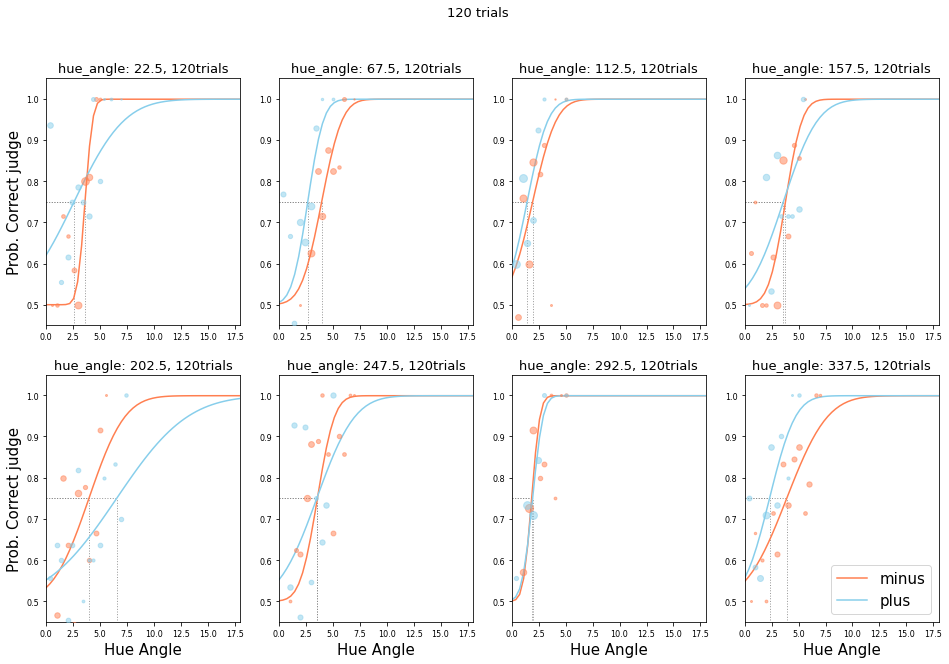

In [7]:
from data_analysis.fit_pf_bayes import FitPf_bayes
test_FitPf = FitPf_bayes(test_ll, ylabel='correct', func='norm')
test_fit_dict = test_FitPf.fit()
test_fit_df = test_FitPf._to_df()
test_FitPf.plot_pf_curve()

ratio_mid = test_fit_df.groupby('hue_angle').nth(0)['PSE']/test_fit_df.groupby('hue_angle').nth(1)['PSE']
ratio_slope = test_fit_df.groupby('hue_angle').nth(0)['JND']/test_fit_df.groupby('hue_angle').nth(1)['JND']

In [8]:
def scale_data(data, ratio):
    scaled_data = []
    for key, grp in ratio.groupby('hue_angle'):
        ratio_val = grp.values[0]
        this_data = data.query("standard_stim == @key")
        this_data['actual_intensity'] = this_data['actual_intensity'].apply(lambda x: x * ratio_val if x > 0 else x)
        scaled_data.append(this_data)
    scaled_data = pd.concat(scaled_data)
    return scaled_data
    
scaled_ll_mid = scale_data(test_ll, ratio_mid)
scaled_lh_mid = scale_data(test_lh, ratio_mid)

scaled_ll_slope = scale_data(test_ll, ratio_slope)
scaled_lh_slope = scale_data(test_lh, ratio_slope)

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
ratio_mid

hue_angle
22.5      1.39316
67.5      1.48302
112.5     1.35938
157.5     1.05584
202.5    0.608079
247.5     1.01725
292.5    0.954023
337.5     1.69062
Name: PSE, dtype: object

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

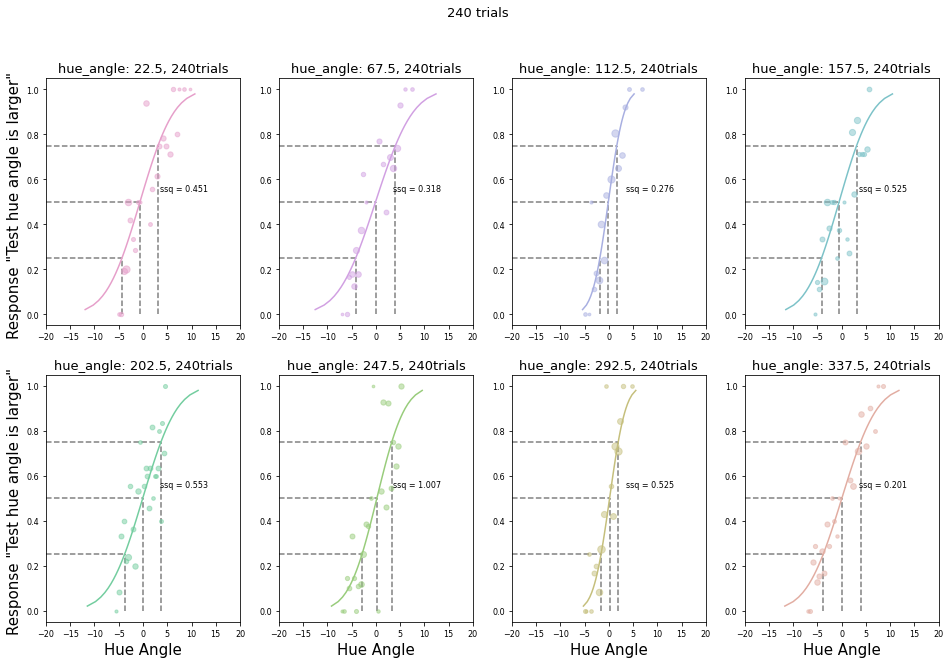

In [10]:
FitPf(scaled_ll_mid).plot_pf_curve()

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

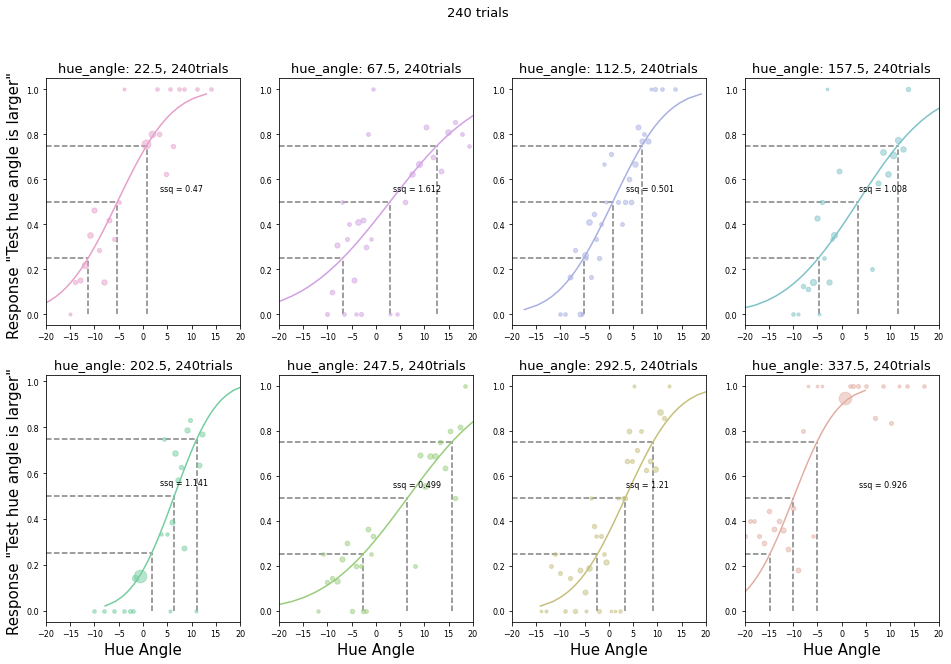

In [11]:
# scaled_ll_mid_FitPf = FitPf(scaled_ll_mid)
# scaled_ll_mid_fit = scaled_ll_mid_FitPf.fit()
# scaled_ll_mid_FitPf.plot_pf_curve()

scaled_lh_mid_FitPf = FitPf(scaled_lh_mid)
scaled_lh_mid_fit = scaled_lh_mid_FitPf.fit()
scaled_lh_mid_FitPf.plot_pf_curve()

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.
Successfully loa

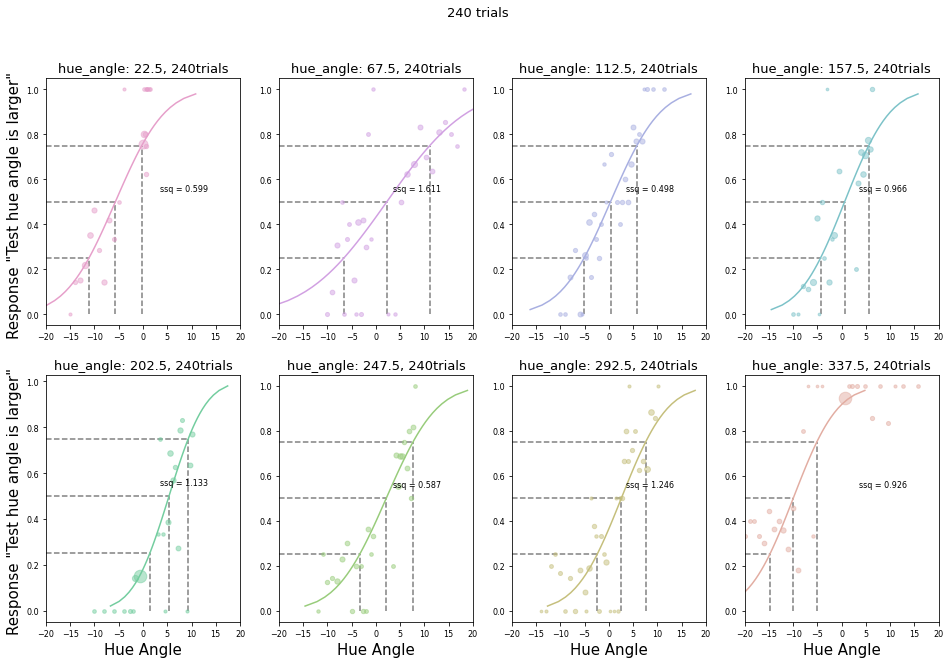

In [12]:
# scaled_ll_slope_FitPf = FitPf(scaled_ll_slope)
# scaled_ll_slope_fit = scaled_ll_slope_FitPf.fit()
# scaled_ll_slope_FitPf.plot_pf_curve()

scaled_lh_slope_FitPf = FitPf(scaled_lh_slope)
scaled_lh_slope_fit = scaled_lh_slope_FitPf.fit()
scaled_lh_slope_FitPf.plot_pf_curve()

/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/su/anaconda3/envs/psychopy/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

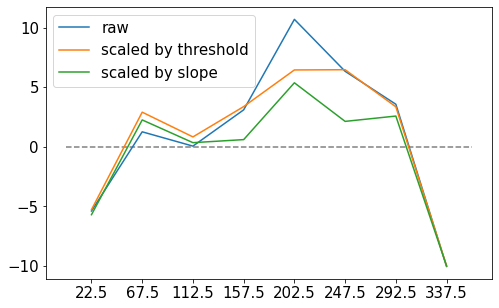

In [13]:
true_lh_fit = test_fit.query("condition == 'LH'")
scaled_lh_mid_fit_df = comp_within_sub('s3', [scaled_lh_mid_fit], ['LH'], plots=False)
scaled_lh_slope_fit_df = comp_within_sub('s3', [scaled_lh_slope_fit], ['LH'], plots=False)

plt.figure(figsize=[8, 5])
plt.plot(true_lh_fit['Hue Angle'], true_lh_fit['PSE'], label='raw')
plt.plot(scaled_lh_mid_fit_df['Hue Angle'], scaled_lh_mid_fit_df['PSE'], label='scaled by threshold')
plt.plot(scaled_lh_slope_fit_df['Hue Angle'], scaled_lh_slope_fit_df['PSE'], label='scaled by slope')

plt.hlines(0, 0, 360, linestyles='dashed', color='gray')
plt.xticks(np.linspace(22.5, 360+22.5, 8, endpoint=False))
plt.legend()
plt.show()

In [23]:
# Compare using Wilcoxon signed-rank test (single sided)
from scipy import stats
stats.wilcoxon(true_lh_fit.PSE.values, scaled_lh_mid_fit_df.PSE.values, alternative='two-sided') 

# stats.wilcoxon(true_lh_fit.PSE.values, scaled_lh_slope_fit_df.PSE.values, alternative='two-sided') 

WilcoxonResult(statistic=12.0, pvalue=0.4609375)

# Further analysis

## Suppl.Test: Difference between JNDs

In [20]:
sAVG_pf_estm = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv')
sAVG_pf_estm_4plot = rep_end(sAVG_pf_estm)

sAVG_pf_estm_4plot.query("condition =='LH'").sort_values(by='Hue Angle')['JND'].to_numpy() - sAVG_pf_estm_4plot.query("condition =='LL'").sort_values(by='Hue Angle')['JND'].to_numpy()

array([2.33346385, 2.33387213, 4.0933984 , 3.35411155, 2.92515942,
       2.60570263, 2.20170777, 3.82094756, 2.33346385, 2.33387213])

Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

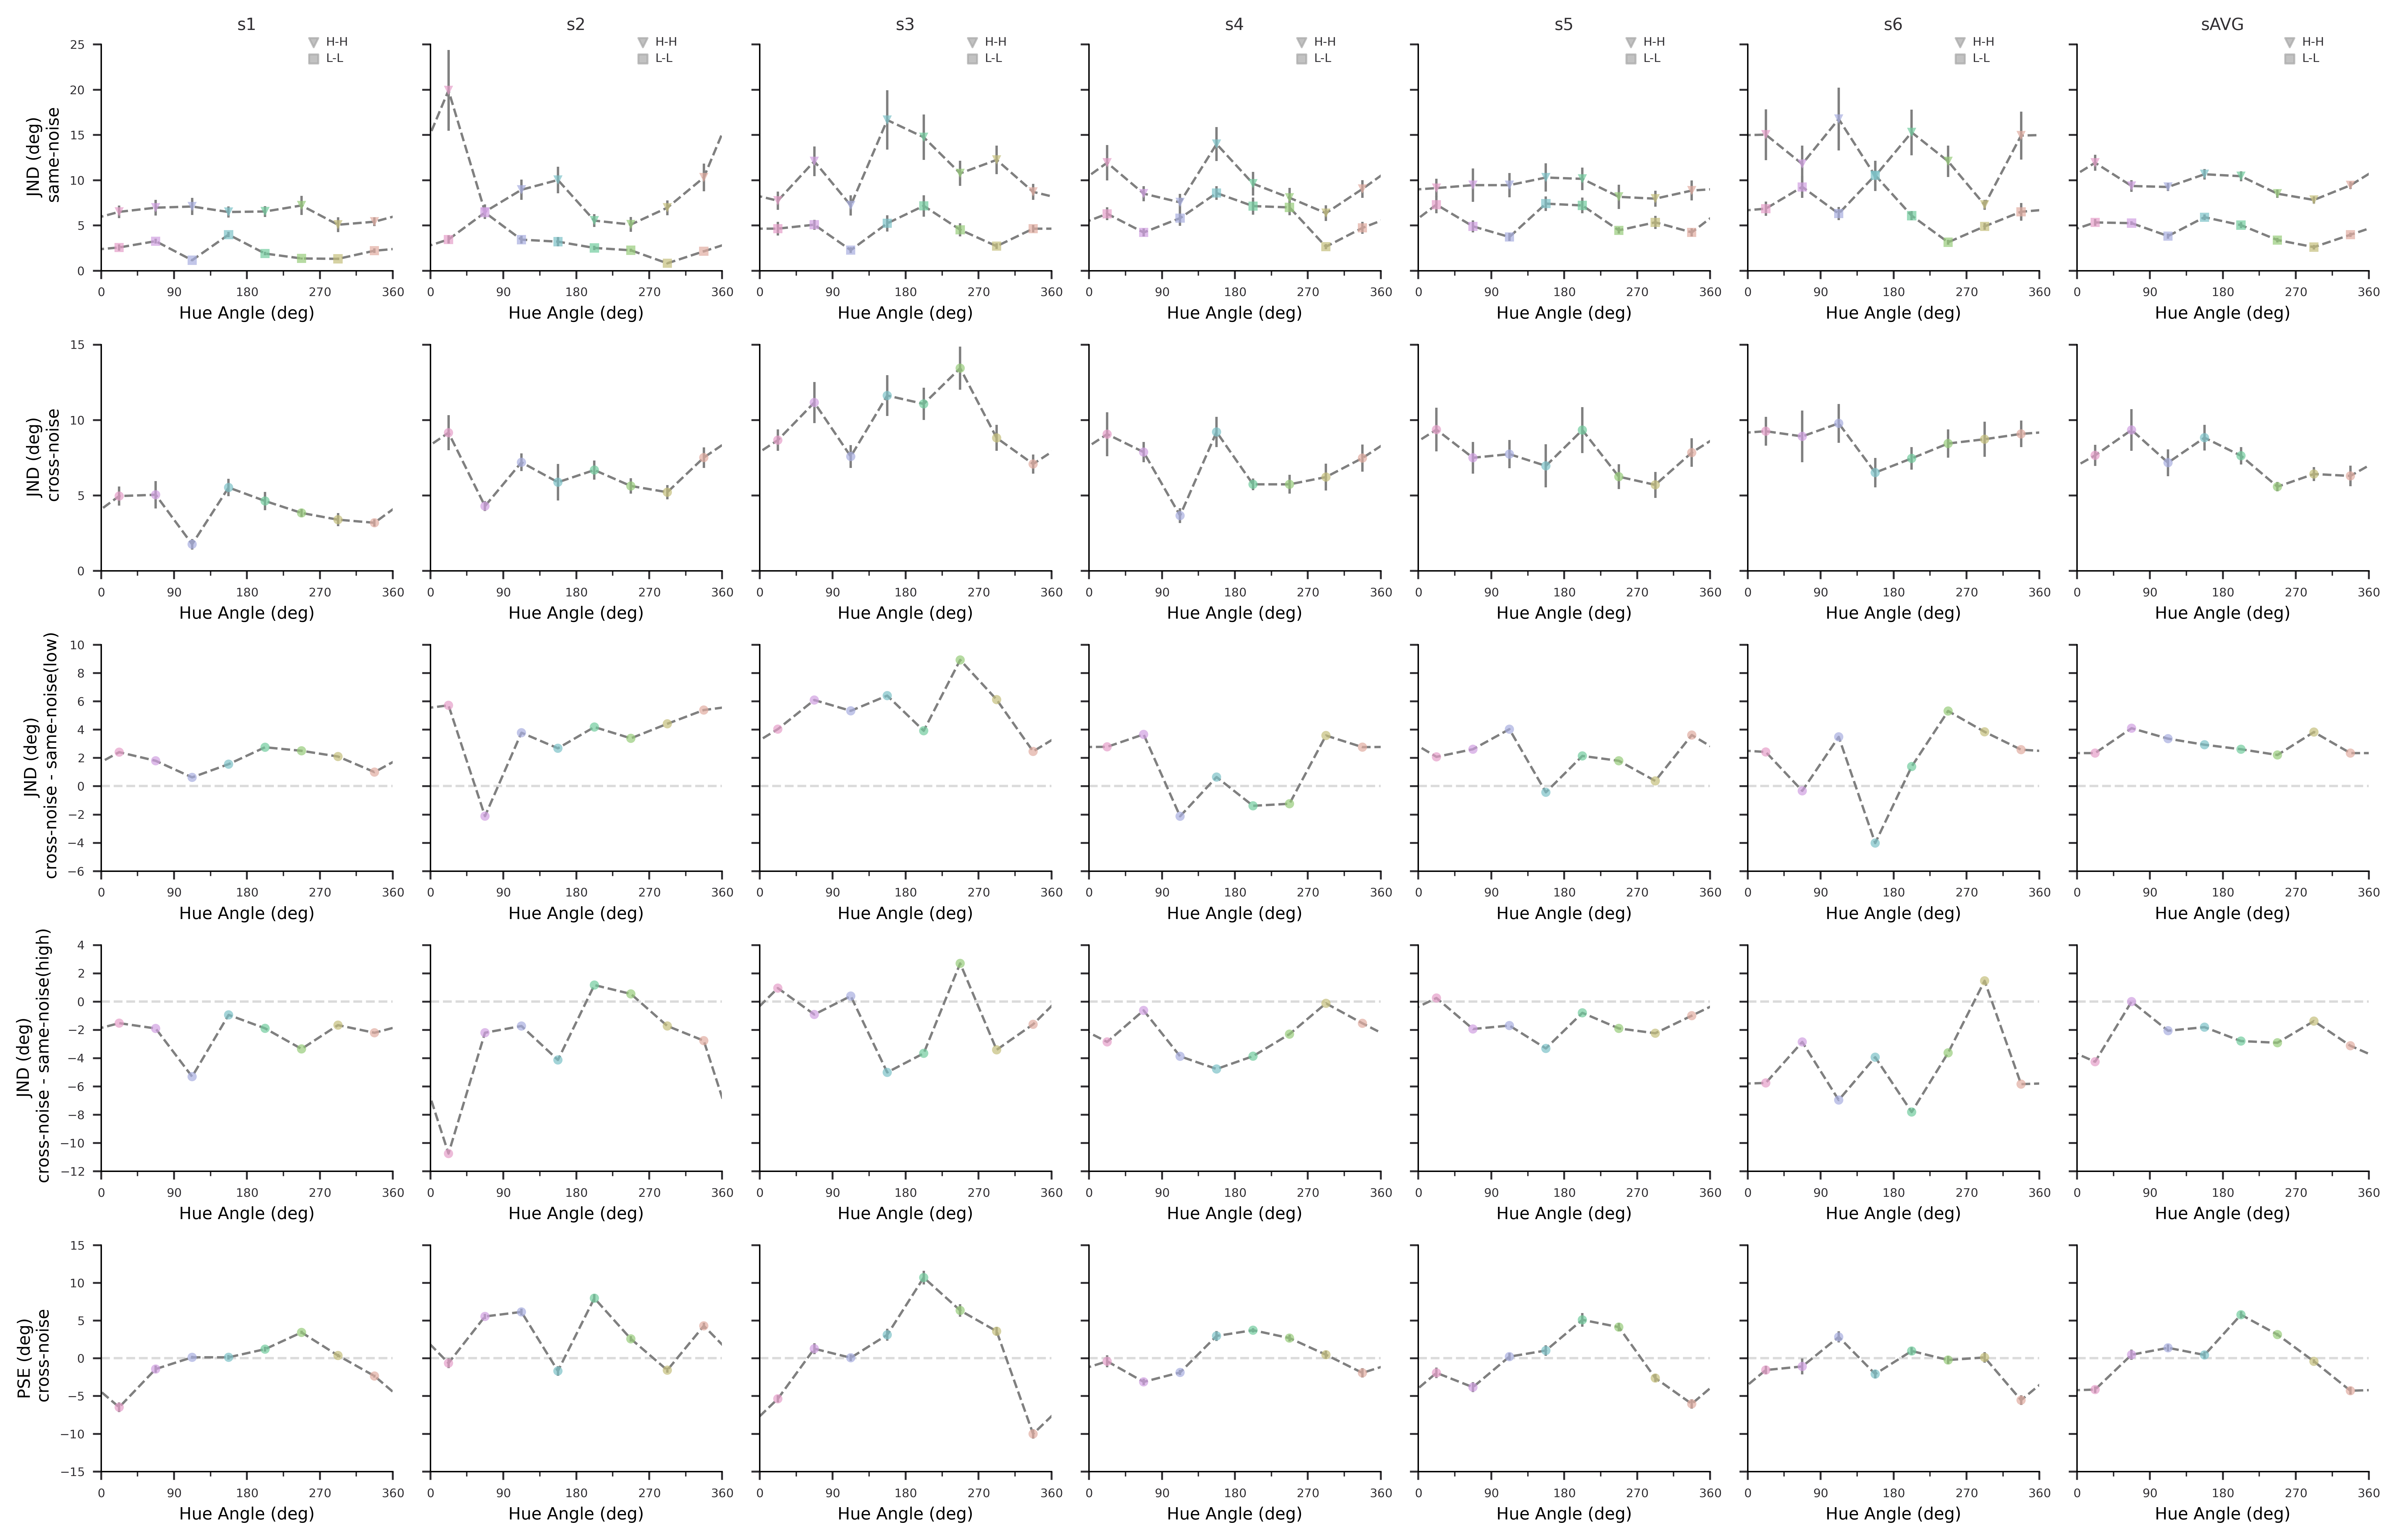

In [56]:
all_pf_estm= pd.read_csv('data_analysis/pf_estimates/all_estimates.csv')
all_pf_estm_4plot = all_pf_estm.groupby('subject').apply(lambda grp: rep_end(grp))
sAVG_pf_estm = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv')
sAVG_pf_estm_4plot = rep_end(sAVG_pf_estm)
hue_angles = np.sort(all_pf_estm_4plot['Hue Angle'].unique())

plt.style.use('data_analysis/figures/plot_style.txt')

cond_cfg = {'labels':
                    {'LL': 'L-L', 
                    'HH': 'H-H', 
                    'LH': 'L-H'},
            'linecolors':
                    {'LL': [.3, .3, .3],
                    'HH': [.7, .7, .7],
                    'LH': [.5, .5, .5]},
            'markers':
                    {'LL': 's',
                    'HH': 'v',
                    'LH': 'o'}}

legend_loc = [0.68, 0.9]

x_major_ticks = np.array([0, 90, 180, 270, 360])
x_minor_ticks = np.linspace(0, 360, 8, endpoint=False)

def behavioral_subplots(estimates, ylim=[[0, 15], [0, 15], [-10, 10]], fig_name=None):
    subs = estimates.subject.unique()
    n_sub = len(subs)
    
    marker_color = color4plot(hue_angles)

    capsize = 4
    alpha = {'line': 1., 'marker': 0.7}

    if n_sub == 2:
        subplot_width, subplot_height = 1.5, 1.5
    else:
        #  subplot_width, subplot_height = fig_width/n_sub, fig_width/n_sub
         subplot_width, subplot_height = 2, 3
    if n_sub == 2:
        fig, axes = plt.subplots(figsize=(subplot_width * n_sub, subplot_height * 3), nrows=5, ncols=n_sub, sharex='none', sharey='row')
    else:
        fig, axes = plt.subplots(figsize=(subplot_width * n_sub, subplot_height * 3), nrows=5, ncols=n_sub, sharex='none', sharey='row')
        
    for i_sub, sub in enumerate(subs):
        sub_estimate = estimates.query("subject == @sub")

        # Plot JND, same-noise
        for key, grp in sub_estimate.query("condition=='LL' or condition=='HH'").groupby('condition'):

            axes[0, i_sub].set_title(sub)
            axes[0, i_sub].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'],c='gray',
                                    linestyle='dashed', capsize=capsize, zorder=2)
            axes[0, i_sub].scatter(x=grp['Hue Angle'], y=grp['JND'],
                                    c=marker_color, marker=cond_cfg['markers'][key], edgecolors='none', alpha=alpha['marker'],
                                    label=cond_cfg['labels'][key], zorder=3, s=15)
            axes[0, i_sub].set_yticks(np.arange(0, 30, step=5))
            # ax[0].set_yscale('log')
            # ax[0].set_ylim([10**(0), 10**1.5])
            axes[0, i_sub].set_ylim(ylim[0])  
            # if n_sub == 2:
            #     axes[0, i_sub].set_ylabel('JND (deg), same-noise')
            leg = axes[0, i_sub].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
            [marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]

        # Plot JND, cross-noise
        # [axes[1, i_sub].vlines(x, 0, 15, alpha=gridline['alpha'], colors=gridline['color'], linewidth=gridline['width'], zorder=1)
        #  for x in x_major_ticks]
        estimates_LH = sub_estimate.query("condition=='LH'")
        axes[1, i_sub].errorbar(x=estimates_LH['Hue Angle'], y=estimates_LH['JND'], yerr=estimates_LH['JND_err'],c='gray',
                        linestyle='dashed', capsize=capsize, zorder=2)
        axes[1, i_sub].scatter(x=estimates_LH['Hue Angle'], y=estimates_LH['JND'],
                        c=marker_color, edgecolors='none', alpha=alpha['marker'],s=15,
                         zorder=3)
        axes[1, i_sub].set_yticks(np.arange(0, 30, step=5))
        # ax[1].set_yscale('log')
        # ax[1].set_ylim([10**(-1), 10**1.5])
        axes[1, i_sub].set_ylim(ylim[1])
        # if n_sub == 2:
        #     axes[1, i_sub].set_ylabel('JND (deg), cross-noise')
        leg = axes[1, i_sub].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
        [marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]

        jnd_diff_low = sub_estimate.query("condition =='LH'").sort_values(by='Hue Angle')['JND'].to_numpy() - sub_estimate.query("condition =='LL'").sort_values(by='Hue Angle')['JND'].to_numpy()
        jnd_diff_high = sub_estimate.query("condition =='LH'").sort_values(by='Hue Angle')['JND'].to_numpy() - sub_estimate.query("condition =='HH'").sort_values(by='Hue Angle')['JND'].to_numpy()
        for jnd, l in zip(enumerate([jnd_diff_low, jnd_diff_high]), ['cross-low', 'cross-high']):
            axes[jnd[0]+2, i_sub].plot(hue_angles, jnd[1],c='gray',
                             linestyle='dashed', zorder=2)
            axes[jnd[0]+2, i_sub].scatter(x=hue_angles, y=jnd[1],
                            c=marker_color, edgecolors='none', alpha=alpha['marker'],
                            label=l, zorder=3, s=15)
            axes[jnd[0]+2, i_sub].hlines(0, 0, 360, alpha=alpha['marker'],  colors=[.8, .8, .8], linestyle='--', zorder=1)
               

        # Plot PSE, cross-noise
        # [axes[2, i_sub].vlines(x, -10, 10,  alpha=gridline['alpha'], colors=gridline['color'], linewidth=gridline['width'], zorder=1)
        #  for x in x_major_ticks]
        # axes[2, i_sub].set_title(sub)
        axes[4, i_sub].errorbar(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'], yerr=estimates_LH['PSE_err'],c='gray',
                        linestyle='dashed', capsize=capsize, zorder=2)
        axes[4, i_sub].scatter(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'],
                        c=marker_color, edgecolors='none', alpha=alpha['marker'],
                        label='L-H', zorder=3, s=15)

        axes[4, i_sub].hlines(0, 0, 360, alpha=alpha['marker'],  colors=[.8, .8, .8], linestyle='--', zorder=1)
        axes[4, i_sub].set_yticks(np.arange(-20, 20, step=5))
        axes[4, i_sub].set_ylim(ylim[2])   
        # if n_sub == 2:
        #     axes[2, i_sub].set_ylabel('PSE (deg), cross-noise')
        

        for i_row in range(5):
            axes[i_row, i_sub].set_xlim([0, 360])
            axes[i_row, i_sub].xaxis.set_minor_locator(plt.FixedLocator(x_minor_ticks))
            axes[i_row, i_sub].xaxis.set_major_locator(plt.FixedLocator(x_major_ticks))
            # plt.setp(axes[:, i_sub].xaxis.get_majorticklabels(), rotation=0)
            # axes[2, i_sub].set_xticks(x_ticks)
            # axes[2, i_sub].set_xticklabels(x_ticks, rotation=45)
            axes[i_row, i_sub].set_xlabel('Hue Angle (deg)')
        
        if n_sub >= 2:
            axes[0, 0].set_ylabel('JND (deg)\n same-noise')
            axes[1, 0].set_ylabel('JND (deg)\n cross-noise')
            axes[2, 0].set_ylabel('JND (deg)\n cross-noise - same-noise(low)')
            axes[3, 0].set_ylabel('JND (deg)\n cross-noise - same-noise(high)')
            axes[4, 0].set_ylabel('PSE (deg)\n cross-noise')


    plt.tight_layout()
    plt.savefig("data_analysis/pf_estimates/pf_estimate_all-in-one.pdf")
    plt.show()


behavioral_subplots(pd.concat([all_pf_estim_4plot, sAVG_pf_estm_4plot]), ylim=[[0, 25], [0, 15], [-15, 15]],)


Successfully loaded calibration from file config/resources/10bit/calibration_10bit.json
Make sure to measure subject's iso-slant with ColorSpace.measure_iso_slant.


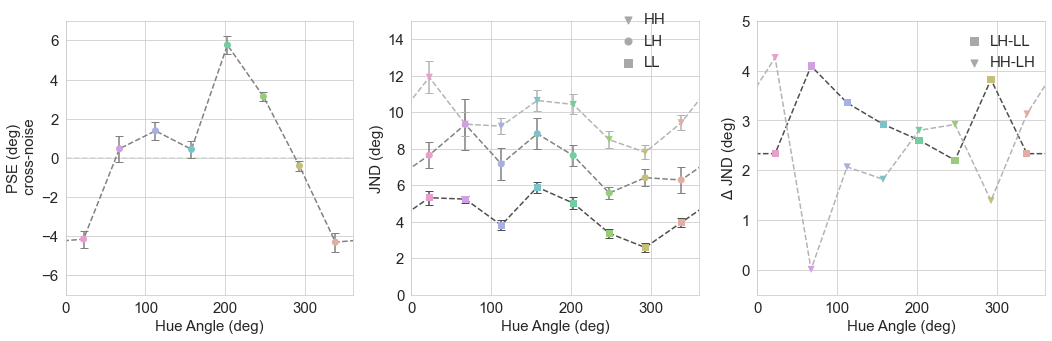

In [79]:
# plot for sAVG, another layout

sAVG_pf_estm = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv')
sAVG_pf_estm_4plot = rep_end(sAVG_pf_estm)
hue_angles = np.sort(sAVG_pf_estm_4plot['Hue Angle'].unique())

marker_color = color4plot(hue_angles)

cond_cfg = {'labels':
                    {'LL': 'LL', 
                    'HH': 'HH', 
                    'LH': 'LH'},
            'linecolors':
                    {'LL': [.3, .3, .3],
                    'HH': [.7, .7, .7],
                    'LH': [.5, .5, .5]},
            'markers':
                    {'LL': 's',
                    'HH': 'v',
                    'LH': 'o'}}
legend_loc = [0.68, 0.8]


import seaborn as sns
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

estimates_LH = sAVG_pf_estm_4plot.query("condition =='LH'")
# plot PSE, cross-noise
axes[0].errorbar(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'], yerr=estimates_LH['PSE_err'],c='gray',
                linestyle='dashed', capsize=4, zorder=2)
axes[0].scatter(x=estimates_LH['Hue Angle'], y=estimates_LH['PSE'],
                c=marker_color, edgecolors='none', alpha=1,
                label='L-H', zorder=3, s=50)

axes[0].hlines(0, 0, 360, alpha=.7,  colors=[.8, .8, .8], linestyle='--', zorder=1)
# axes[0].set_yticks(np.arange(-20, 20, step=5))
# axes[0].set_ylim(ylim[2])   
axes[0].set_xlim([0, 360])
axes[0].set_ylim([-7, 7])
axes[0].set_xlabel('Hue Angle (deg)')
axes[0].set_ylabel('PSE (deg)\n cross-noise')


# show all JNDs in one plot
for key, grp in sAVG_pf_estm_4plot.groupby('condition'):

    axes[1].errorbar(x=grp['Hue Angle'], y=grp['JND'], yerr=grp['JND_err'],
                            linestyle='dashed', capsize=4, zorder=2, c=cond_cfg['linecolors'][key])
    axes[1].scatter(x=grp['Hue Angle'], y=grp['JND'],
                            c=marker_color, marker=cond_cfg['markers'][key], edgecolors='none', alpha=1,
                            label=cond_cfg['labels'][key], zorder=3, s=50)
    axes[1].set_yticks(np.arange(0, 30, step=2))
    axes[1].set_ylim([0, 15])  
    axes[1].set_xlim([0, 360])
    leg = axes[1].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
    [marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]
    axes[1].set_xlabel('Hue Angle (deg)')
    axes[1].set_ylabel('JND (deg)')

# show JND difference in one plot
jnd_diff_low = sAVG_pf_estm_4plot.query("condition =='LH'").sort_values(by='Hue Angle')['JND'].to_numpy() - sAVG_pf_estm_4plot.query("condition =='LL'").sort_values(by='Hue Angle')['JND'].to_numpy()
jnd_diff_high = sAVG_pf_estm_4plot.query("condition =='HH'").sort_values(by='Hue Angle')['JND'].to_numpy() - sAVG_pf_estm_4plot.query("condition =='LH'").sort_values(by='Hue Angle')['JND'].to_numpy()
for jnd, l in zip(enumerate([jnd_diff_low, jnd_diff_high]), ['LH-LL', 'HH-LH']):
        axes[2].plot(hue_angles, jnd[1],c=list(cond_cfg['linecolors'].values())[jnd[0]],
                        linestyle='dashed', zorder=2)
        axes[2].scatter(x=hue_angles, y=jnd[1], marker=list(cond_cfg['markers'].values())[jnd[0]],
                        c=marker_color, edgecolors='none', alpha=1,
                        label=l, zorder=3, s=50)
axes[2].set_xlim([0, 360])
axes[2].set_ylim([-0.5, 5])
axes[2].set_xlabel('Hue Angle (deg)')
axes[2].set_ylabel('$\\Delta$ JND (deg)')
leg = axes[2].legend(loc=legend_loc, frameon=False, handletextpad=0.05)
[marker.set_color([.66, .66, .66]) for marker in leg.legendHandles]

plt.tight_layout()
plt.savefig("data_analysis/pf_estimates/sAVG_pf_estimate_all-in-one.pdf")

# Check distribution of samples

In [3]:
n_btrp = 100

sub_lh_data = pd.read_csv('data/all_sel_data.csv').query("condition == 'LH' and subject =='s03'")

sample_resp_ls = []
for i in range(n_btrp):
    this_sample = sub_lh_data.groupby(['standard_stim', 'actual_intensity']).sample(frac=1., replace=True)
    btrp_resp = this_sample.groupby(['standard_stim', 'actual_intensity'])['resp_as_larger'].agg(['mean', 'count']).reset_index()
    btrp_resp['i_btrp'] = i
    sample_resp_ls.append(btrp_resp)
sample_resp = pd.concat(sample_resp_ls, ignore_index=True)
sample_resp

standard_stim  actual_intensity      mean  count  i_btrp
0               22.5             -15.0  0.000000      2       0
1               22.5             -14.0  0.142857      7       0
2               22.5             -13.0  0.153846     13       0
3               22.5             -12.0  0.217391     23       0
4               22.5             -11.0  0.235294     17       0
...              ...               ...       ...    ...     ...
21795          337.5               5.0  1.000000      4      99
21796          337.5               6.0  1.000000      6      99
21797          337.5               7.0  1.000000      2      99
21798          337.5               8.0  1.000000      4      99
21799          337.5              10.0  1.000000      4      99

[21800 rows x 5 columns]

No handles with labels found to put in legend.


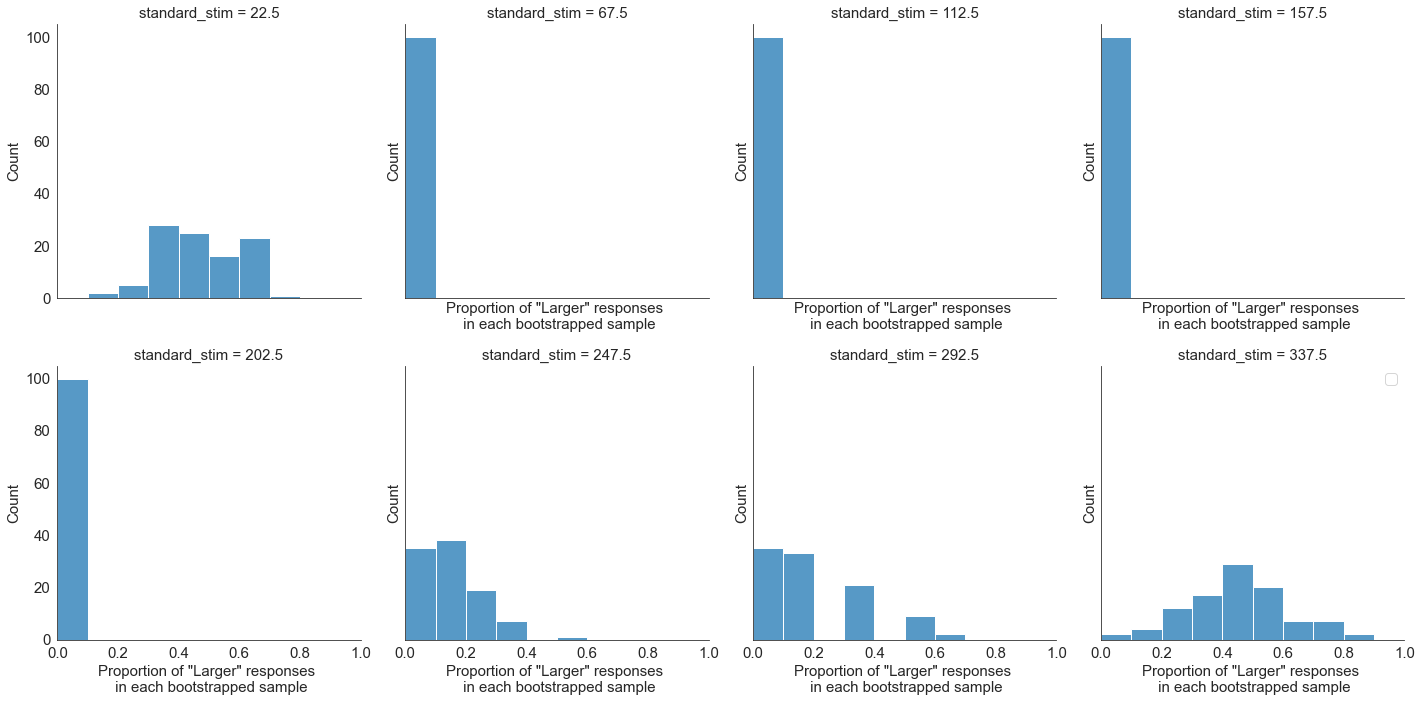

In [5]:
import seaborn as sns

sns.set_style('white')
g = sns.displot(sample_resp.query("actual_intensity==-10"), x='mean', col='standard_stim', binwidth=.1, col_wrap=4)
g.set(xlim=[0, 1], xlabel='Proportion of "Larger" responses \n in each bootstrapped sample', ylabel='Count')
plt.legend()
plt.tight_layout()

In [7]:
sub_lh_data.query("standard_stim==67.5 and actual_intensity==-10")

Unnamed: 0  trial_index    stimulus  standard_stim  test_stim  \
15483    trial_4         12.0  stimulus_0           67.5       57.5   
15723    trial_4         12.0  stimulus_0           67.5       57.5   
15827  trial_108        116.0  stimulus_0           67.5       57.5   
15831  trial_112        120.0  stimulus_0           67.5       57.5   
16441    trial_2         10.0  stimulus_0           67.5       57.5   
16681    trial_2         10.0  stimulus_0           67.5       57.5   

      standard_xlim     test_xlim  calculated_intensity  actual_intensity  \
15483  [-4.5, -1.5]    [4.5, 1.5]                 -10.0             -10.0   
15723  [-4.5, -1.5]    [4.5, 1.5]                 -10.0             -10.0   
15827  [-4.5, -1.5]    [4.5, 1.5]                 -10.0             -10.0   
15831    [4.5, 1.5]  [-4.5, -1.5]                 -10.0             -10.0   
16441    [4.5, 1.5]  [-4.5, -1.5]                 -10.0             -10.0   
16681  [-4.5, -1.5]    [4.5, 1.5]                 -10.0             -10.0   

      press_key  judge  react_time  trial_time_stamp     time_index  \
15483      down      1    0.834885      1.625397e+09  20210704T1302   
15723      down      1    0.827573      1.625995e+09  20210711T1111   
15827  ['down']      1    0.770159      1.625995e+09  20210711T1111   
15831        up      1    1.362934      1.625995e+09  20210711T1111   
16441    ['up']      1    0.776601      1.626603e+09  20210718T1202   
16681      down      1    0.810792      1.626677e+09  20210719T0834   

       resp_as_larger condition subject  
15483               0        LH     s03  
15723               0        LH     s03  
15827               0        LH     s03  
15831               0        LH     s03  
16441               0        LH     s03  
16681               0        LH     s03